In [303]:
import fmpsdk
import pandas as pd
import numpy as np
apikey =
from datetime import datetime, timedelta
import plotly.graph_objects as go
import plotly.express as px
import urllib.request
import dash_bootstrap_components as dbc
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pandas.plotting import lag_plot
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from keras.metrics import mean_absolute_error
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import warnings
warnings.filterwarnings('ignore')

# Business Problem: Stock prices are a a very important metric because they represent the value of publicly traded companies in  the eyes of society. There is also a strong financial incentive to have a higher stock value for current shareholders because stocks can be liquidated into currency. Stock prices fluctuate based on the supply and demand of stocks associated with a particular company. If stock price can be predicted it could bring these business values:
#### - Increased confidence of return when investing in a company's stock
#### - Increase the confidence of current shareholders regarding stock's direction which can influence their decision to buy/sell your stock
#### - Determine key metrics that drive a stock price up or down
#### - Forecasting stock crashes will lead to the minimization of capital loss
 

# Business Understanding: Predicting stock prices is not an easy task especially regarding the number of variables that go into it. Knowing that a stock price fluctuates based on supply and demand tells me how I will move forward. If I can collect general public sentiment towards a stock, current market trends, and the stock's recent direction, then I am confident that I can predict a stock's price. I will make two types of models for individual stocks, one that predicts the end of day price and one that predicts the price in 4 hours.

# Obtain
#### The Plan:
- Build a general ARIMA model that will predict the next day close of any stock
- To start I will build the model based on a single stock
- Final product will be a function that will have one parameter, stock symbol, that creates and ARIMA model predicting the stock close.
- I will also create a visualization that follows the stock price and also shows the model prediction.
- Ultimately, a user interacting with the dashboard will be able to select a graph that shows this prediction vs actual line plot and will also print out the predicted close price.

#### Alternative Plan:
- Build an XGBOOST model that will predict next day stock_close

In [61]:
day_stock = fmpsdk.historical_price_full(apikey, 'AMZN')

In [62]:
len(day_stock)

2

In [63]:
type(day_stock)

dict

In [64]:
day_stock.keys()

dict_keys(['symbol', 'historical'])

In [65]:
len(day_stock['historical'])

1258

In [66]:
(day_stock['historical'])[0]

{'date': '2021-11-19',
 'open': 3712.69,
 'high': 3762.145,
 'low': 3675.72,
 'close': 3676.57,
 'adjClose': 3676.57,
 'volume': 4946203.0,
 'unadjustedVolume': 4946203.0,
 'change': -36.12,
 'changePercent': -0.973,
 'vwap': 3704.81167,
 'label': 'November 19, 21',
 'changeOverTime': -0.00973}

#### The API allows for the amount of data to be collected to be changed. Considering that it called 1258 days for the AMZN ticker above, I will leave this parameter empty. Next I need to get the data into matrix form.

In [67]:
def build_time_series_df(stock):
    """
    IN: stock : Stock symbol that will be used to build the time series data
    
    OUT: day_df : Dataframe that returns with columns date, close, high,
    change_over_time, volume, and date
    
    """
    #Determine date range, will start with 200 days in the past
    today = datetime.now()
    end_date = today - timedelta(days=200)
    day_stock = fmpsdk.historical_price_full(apikey, stock, from_date = end_date,
                                            to_date = today)
    
    #Construct Dataframe
    day_df = pd.DataFrame(columns = ['Date', 'Close', 'High', 'Change Over Time',
                                    'Volume'])
    dates = []
    closes = []
    highs = []
    change_over_time = []
    changes = []
    volumes = []
    

    #Fill Dataframe
    for day in day_stock['historical']:
        dates.append(day['date'])
        closes.append(day['close'])
        highs.append(day['high'])
        change_over_time.append(day['changeOverTime'])
        volumes.append(day['volume'])
        

    day_df.Date = dates
    day_df.Close = closes
    day_df.High = highs
    day_df['Change Over Time'] = change_over_time
    day_df.Volume = volumes

    day_df.Date = day_df.Date.apply(lambda dat: pd.to_datetime(dat))
    #day_df.Date = day_df.Date.apply(lambda dat: str(dat)[5:10])
 
    return day_df


In [305]:
amzn_df = build_time_series_df('AMZN')

#### I will now take a quick look at autocorrelation plot for the data.

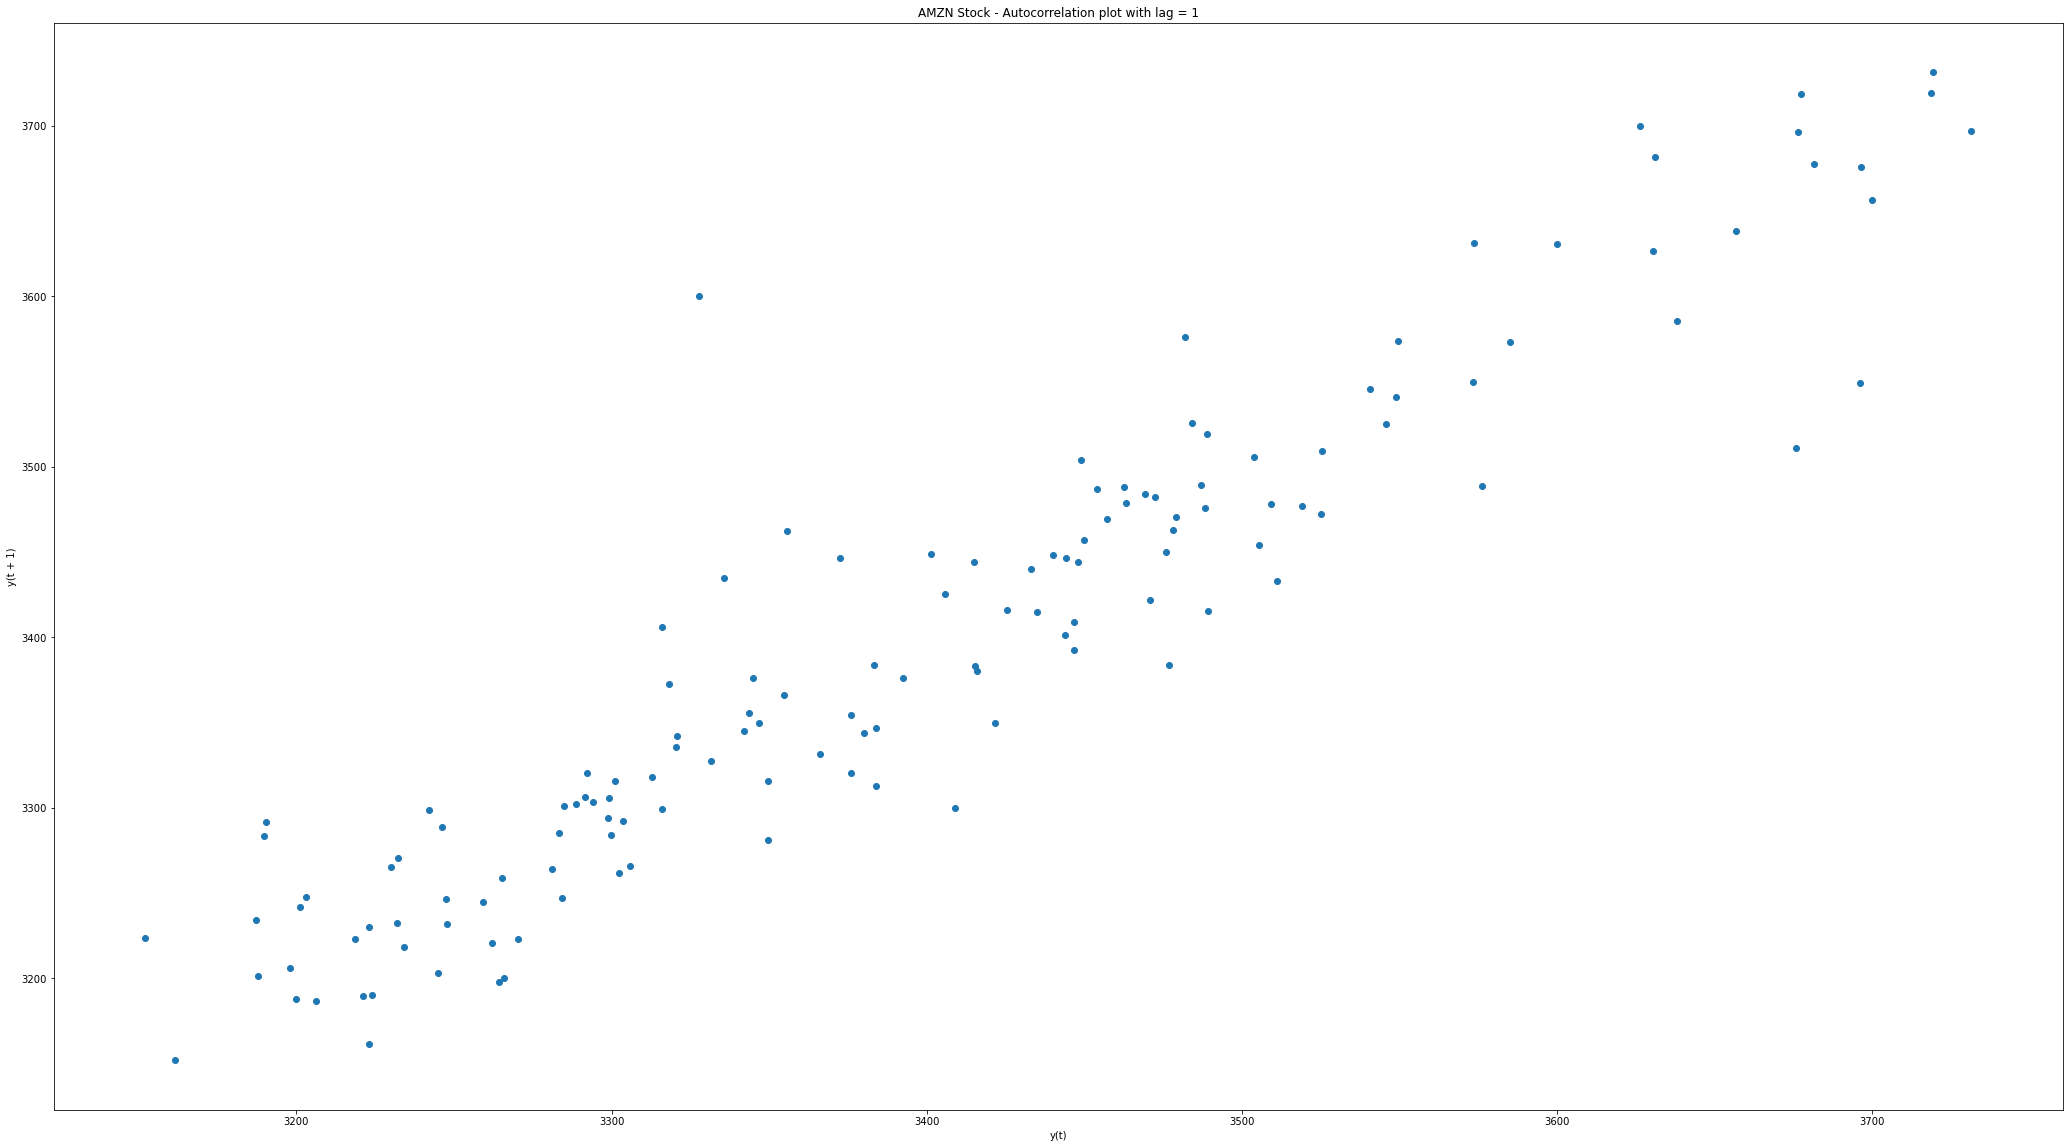

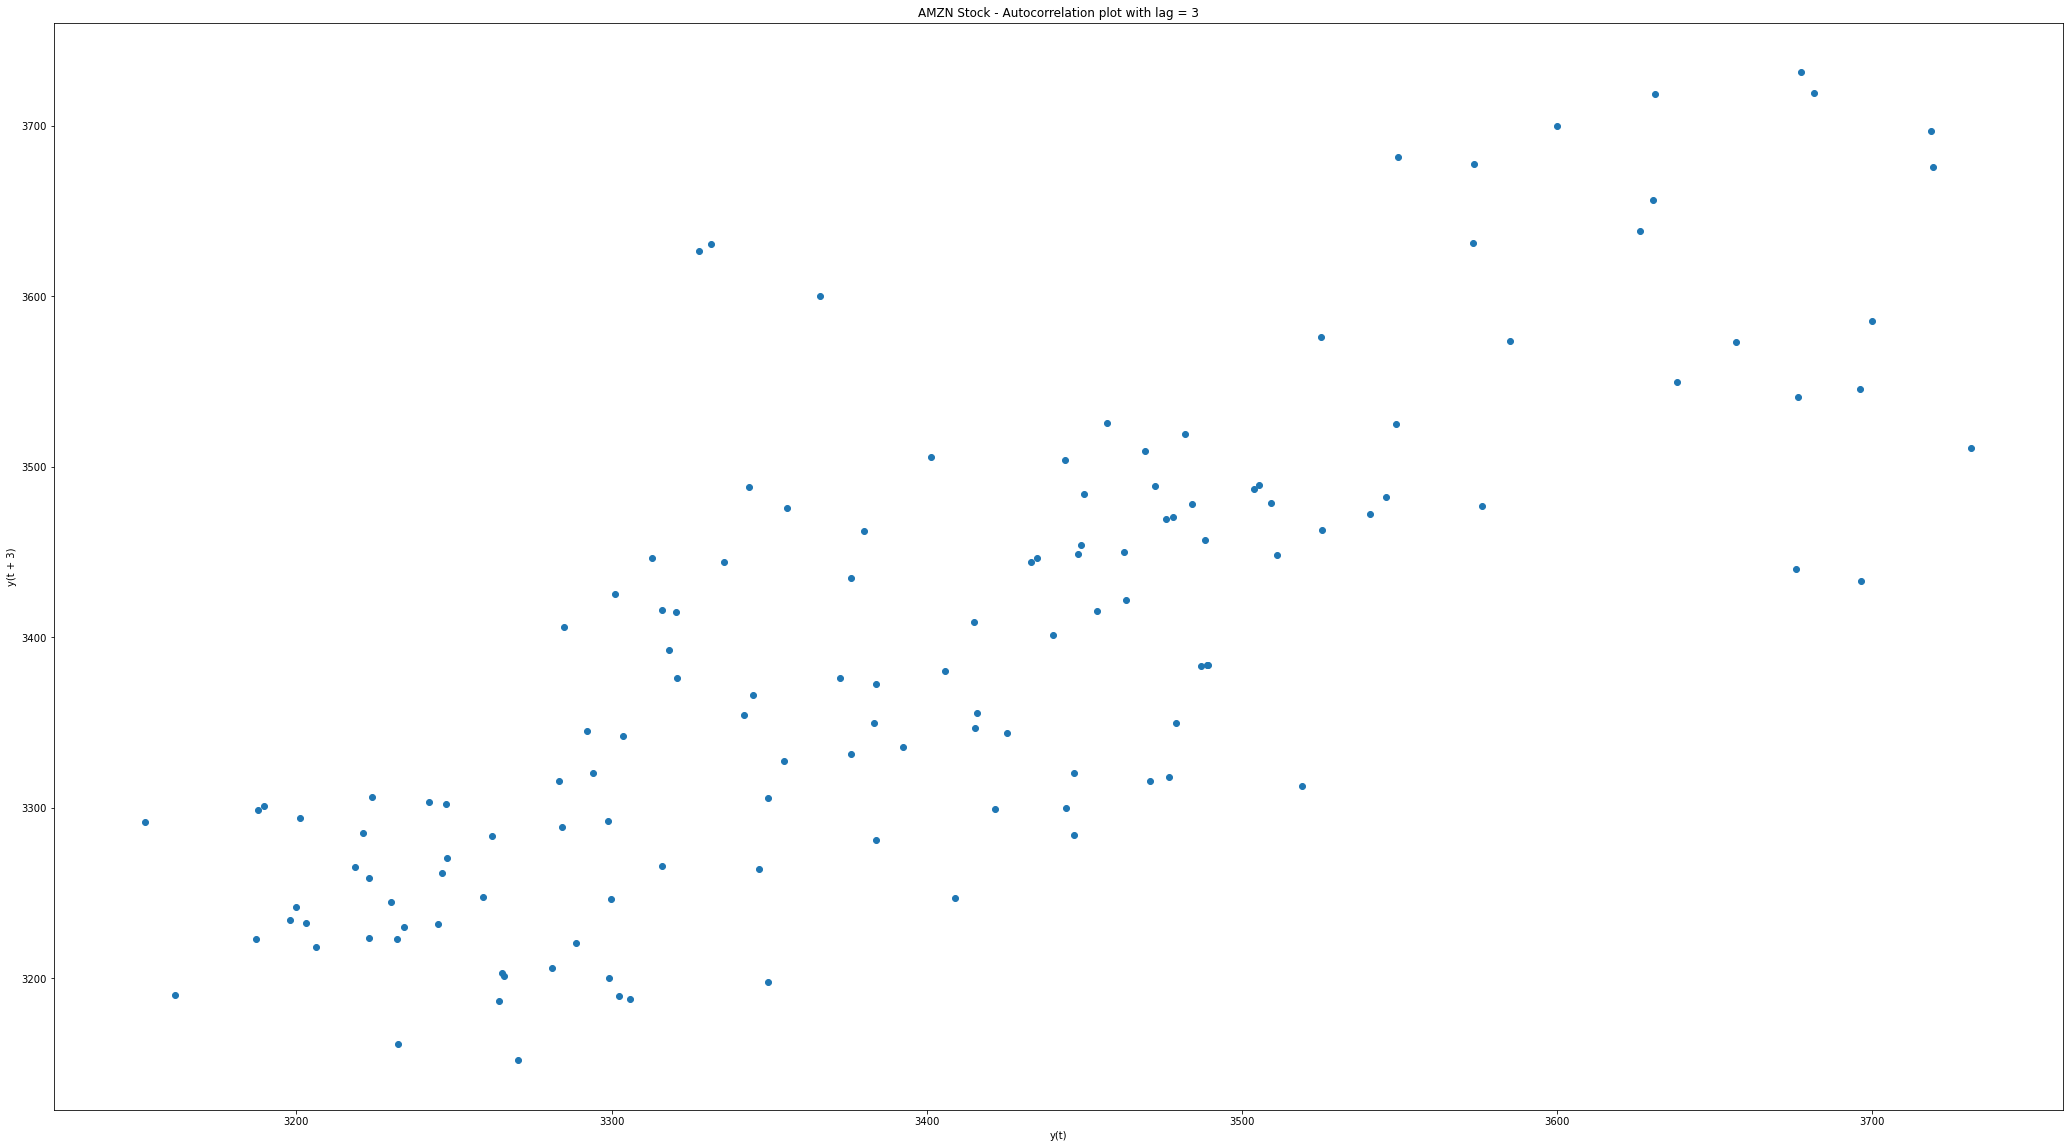

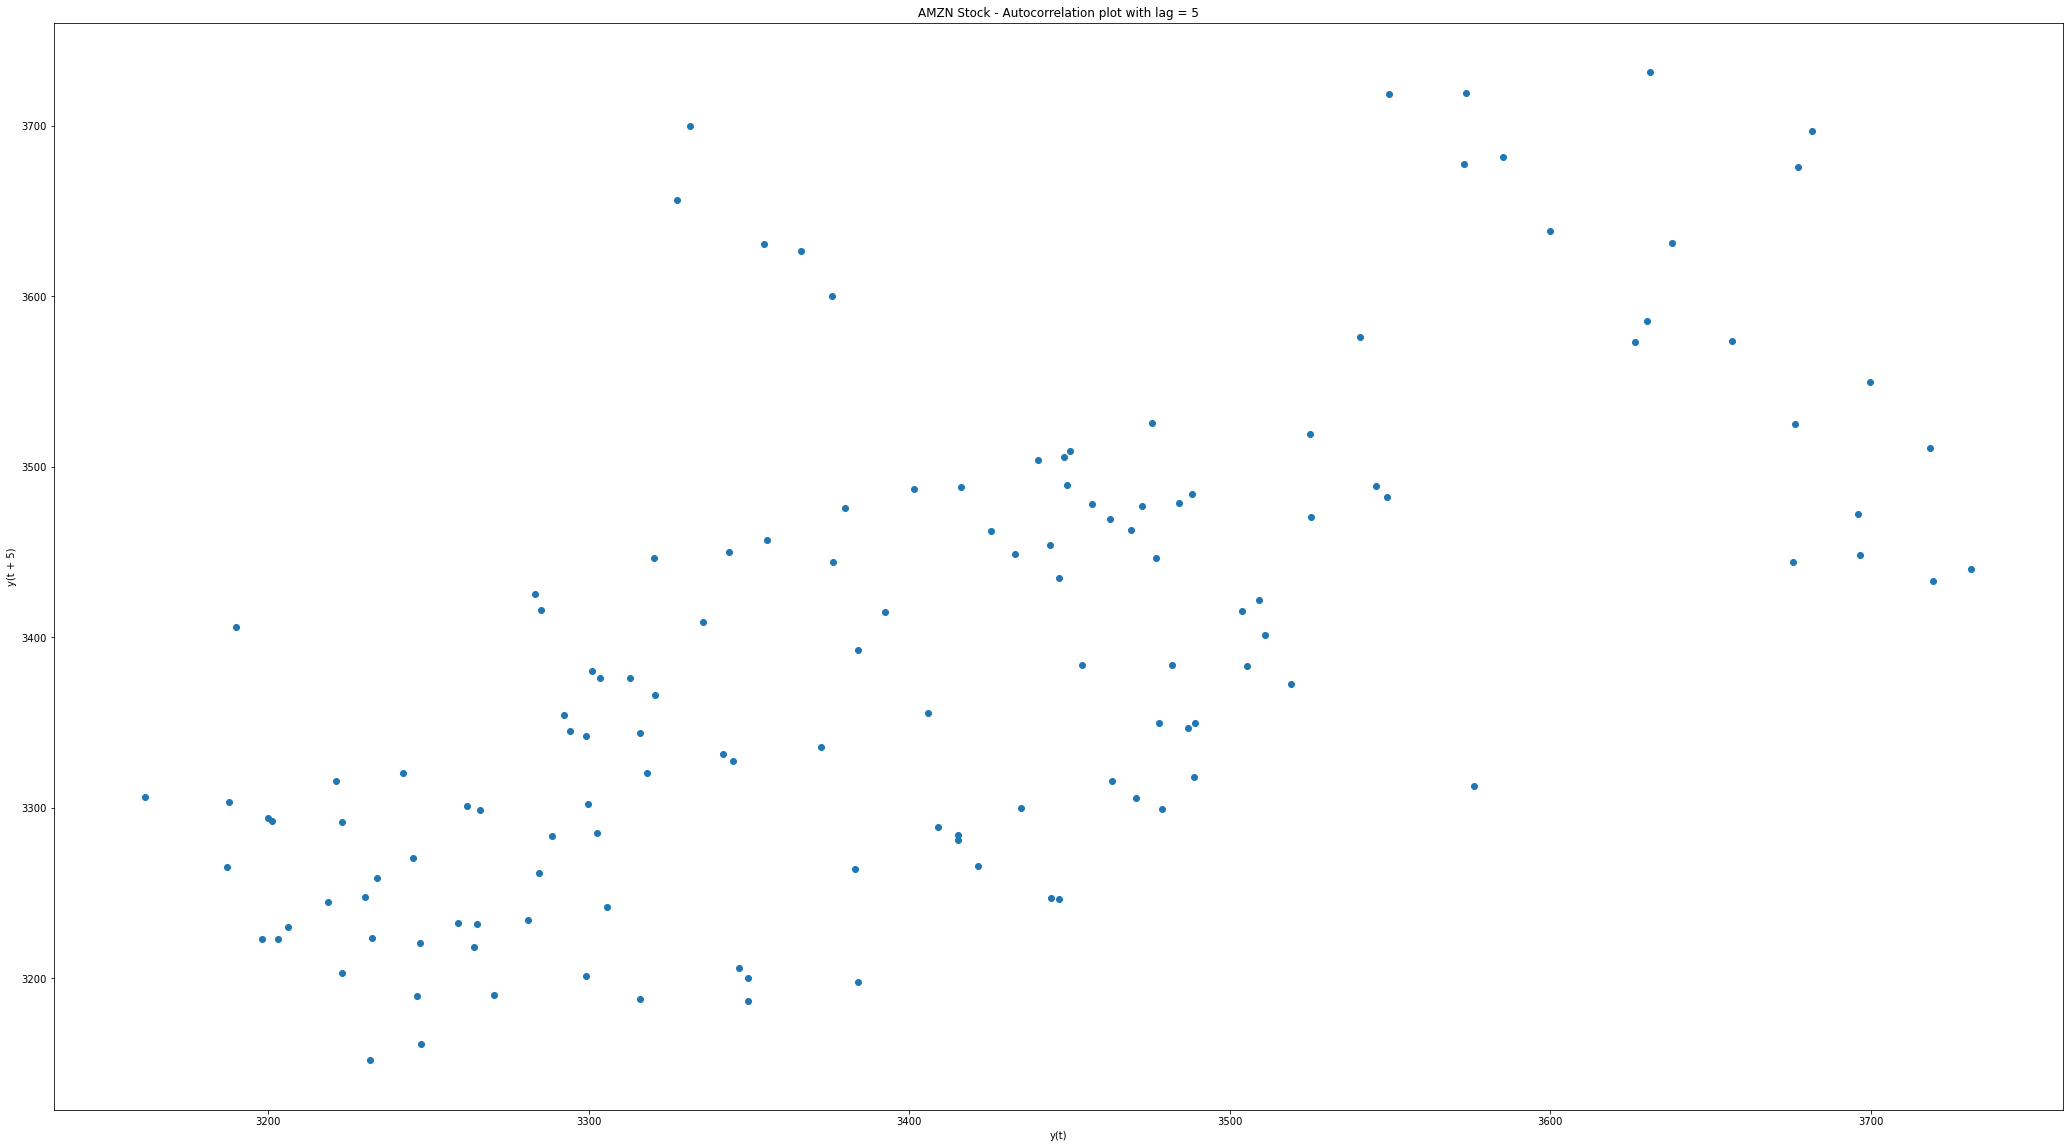

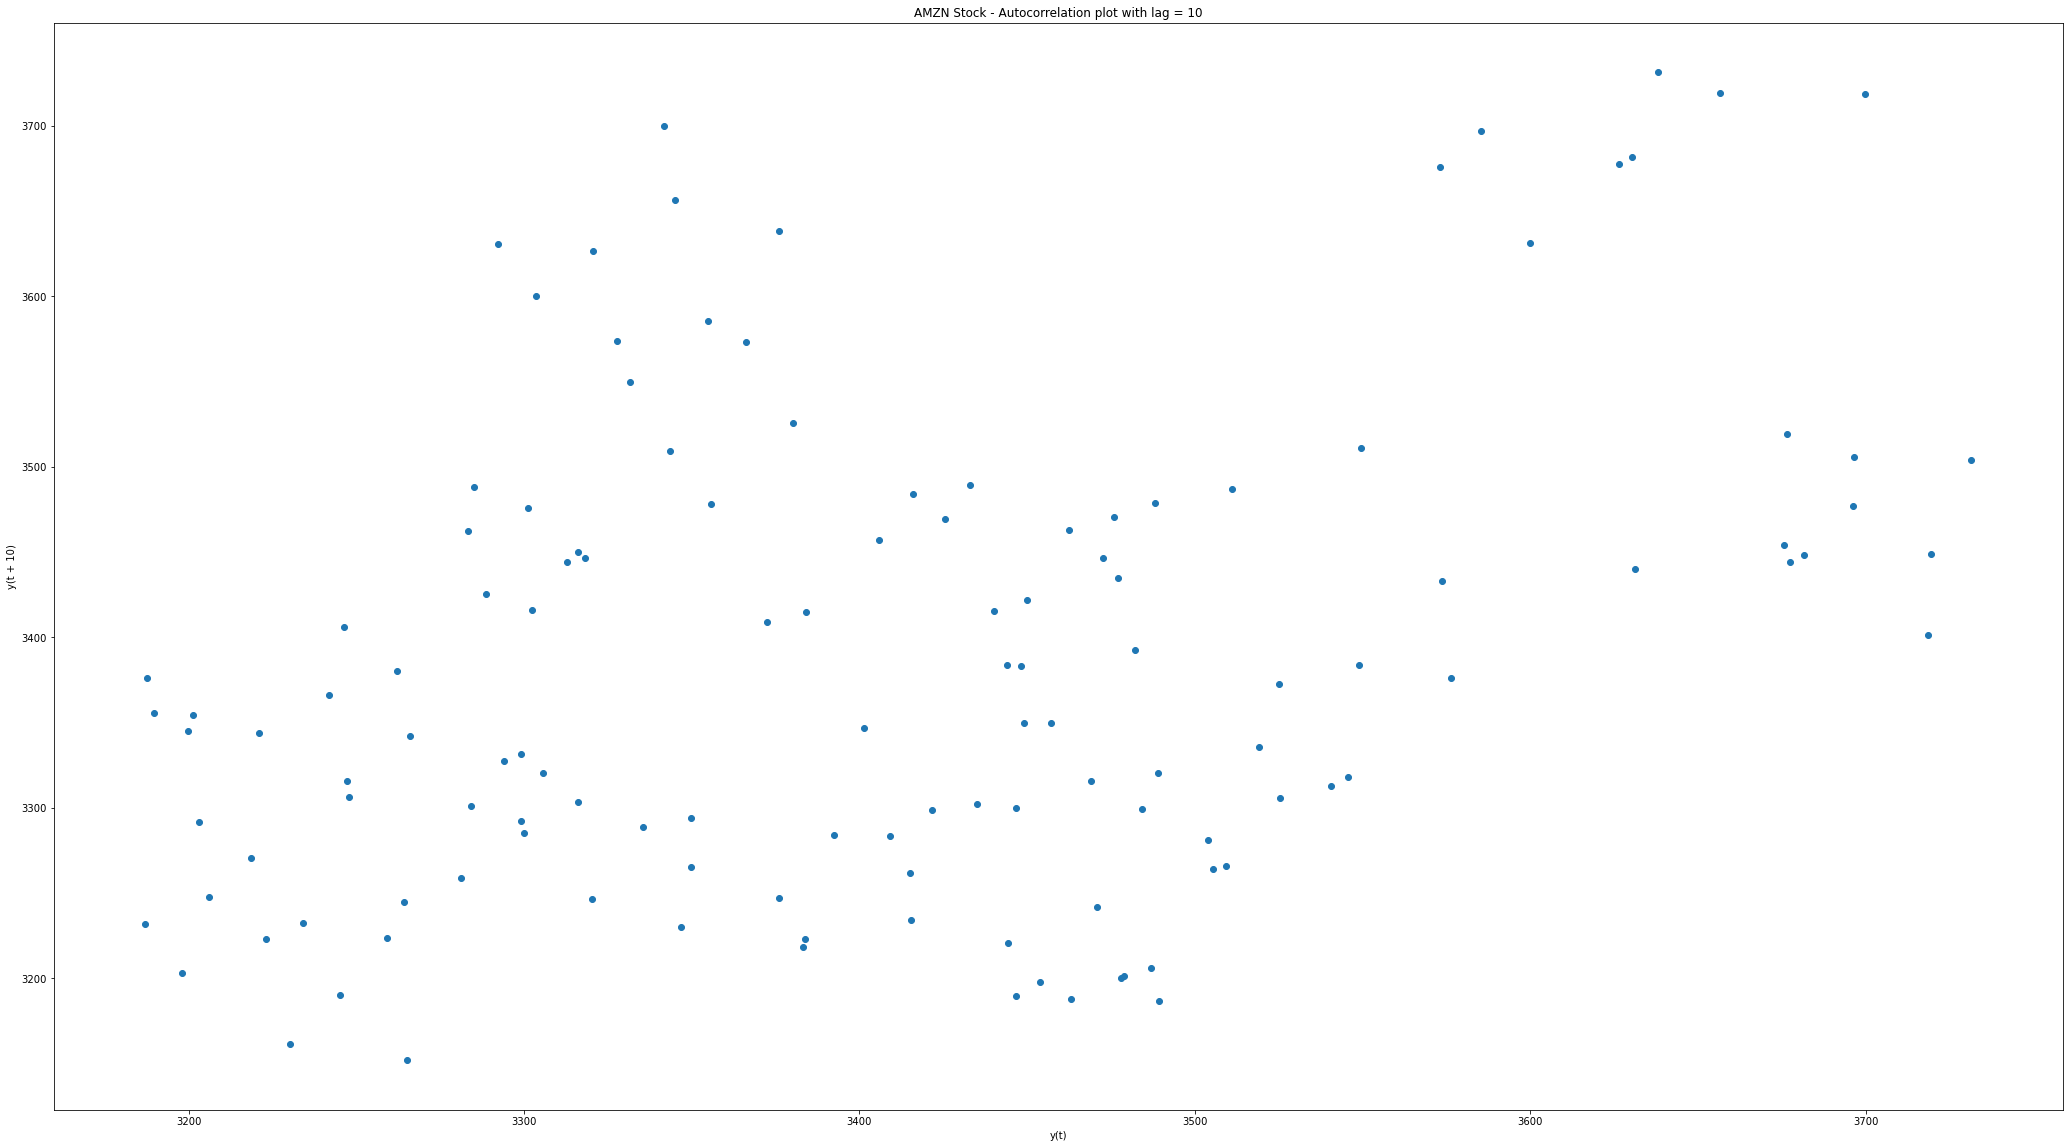

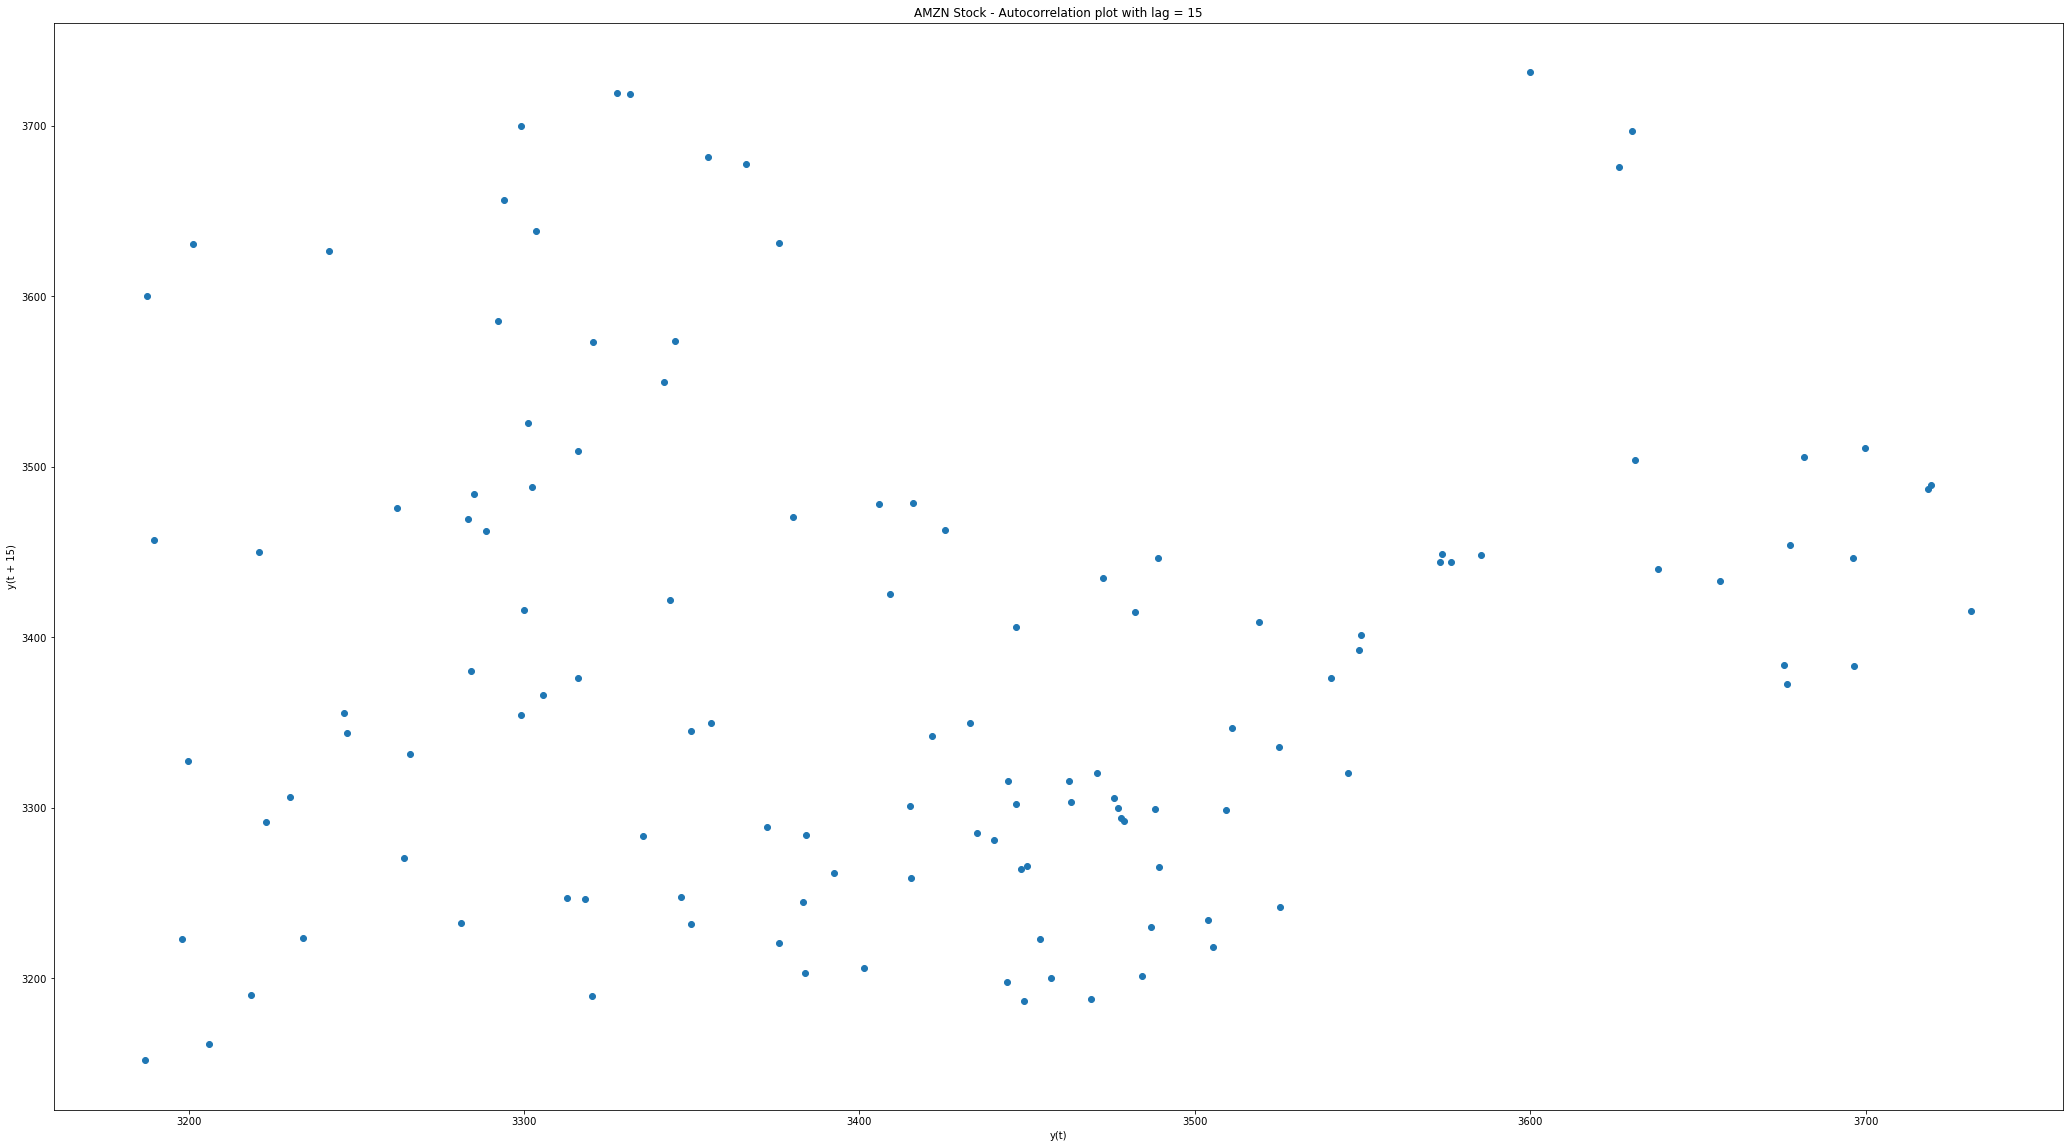

In [122]:
lags = [1, 3, 5, 10, 15]


for lag_ in lags:
    plt.figure()
    lag_plot(amzn_df['Close'], lag=lag_)
    plt.title('AMZN Stock - Autocorrelation plot with lag = '+str(lag_))
    plt.show()

#### Based on the charts above we can concluse that an ARIMA model is correct for our use but lag should remain under 50. I will now look at stationarity using the ADF test. If the p-value > .05 I need to find the order of differencing.

In [123]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(amzn_df.Close)
print(f"ADF Stats: {result[0]} ")
print(f"p-value: {result[1]} ")

ADF Stats: -2.896334236901429 
p-value: 0.04577593947532271 


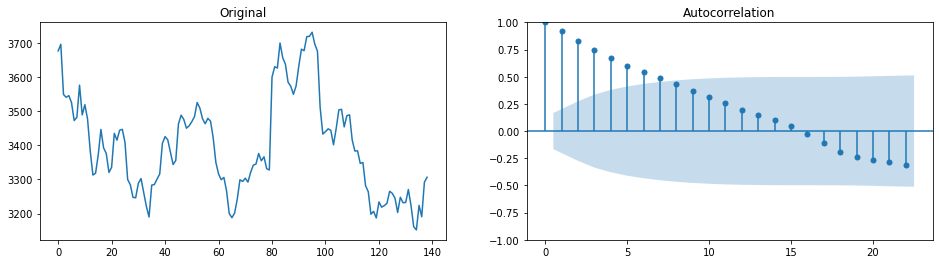

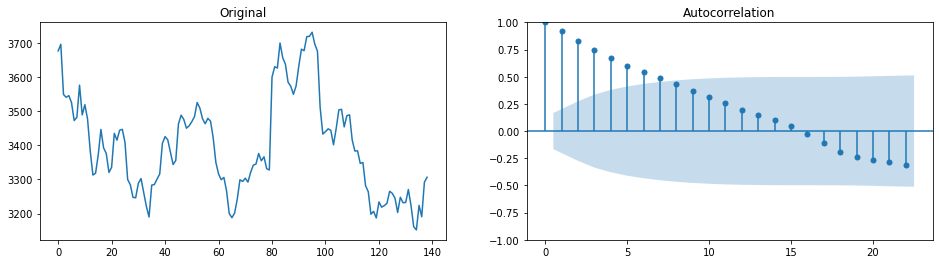

In [124]:
from statsmodels.graphics.tsaplots import plot_acf
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(amzn_df.Close)
ax1.set_title('Original')
plot_acf(amzn_df.Close, ax=ax2)

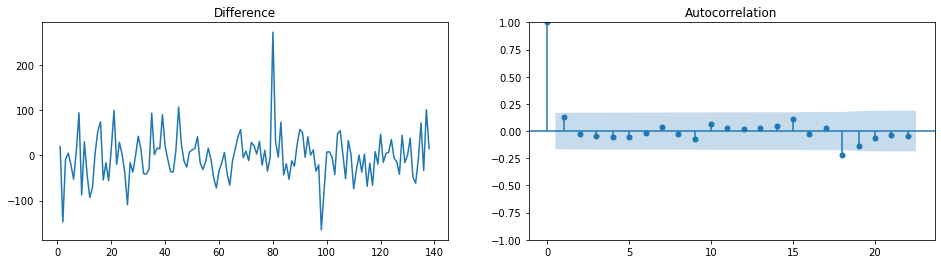

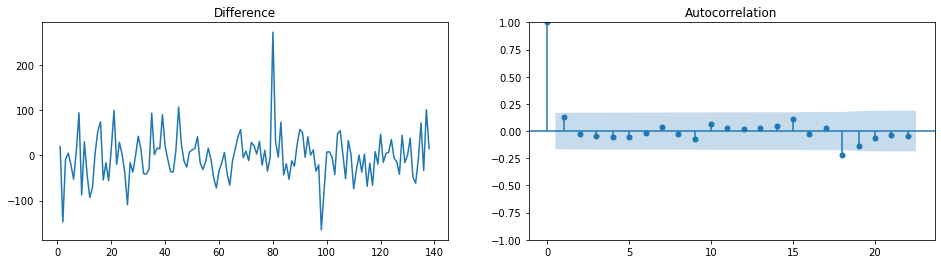

In [125]:
diff = amzn_df.Close.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title('Difference')
plot_acf(diff, ax=ax2)

# Train Test Split

In [307]:
amzn_df.head()

,Date,Close,High,Change Over Time,Volume
0,2021-11-19,3676.5700,3762.1450,-0.00973,4946203.0
1,2021-11-18,3696.0601,3704.2000,0.03637,5564319.0
2,2021-11-17,3549.0000,3587.2451,-0.00441,2560322.0
3,2021-11-16,3540.7000,3576.5000,0.00048,2060577.0
4,2021-11-15,3545.6799,3593.8799,0.00245,2547085.0


In [308]:
test_data, train_data = amzn_df[0:int(len(amzn_df)*.7)], \
                            amzn_df[int(len(amzn_df)*.7):]

train = train_data['Close'].values
test = test_data['Close'].values


# Model

In [310]:
train = train_data['Close'].values
test = test_data['Close'].values
# Create list of x train valuess
history = [x for x in train]
# establish list for predictions
model_predictions = []
# Count number of test data points
N_test_observations = len(test)
# loop through every data point
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(5,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test[time_point]
    history.append(true_test_value)
MAE_error = mean_absolute_error(test, model_predictions).numpy()
print('Testing Mean Absolute Error is {}'.format(MAE_error))



Testing Mean Absolute Error is 45.507402072872544


# Results

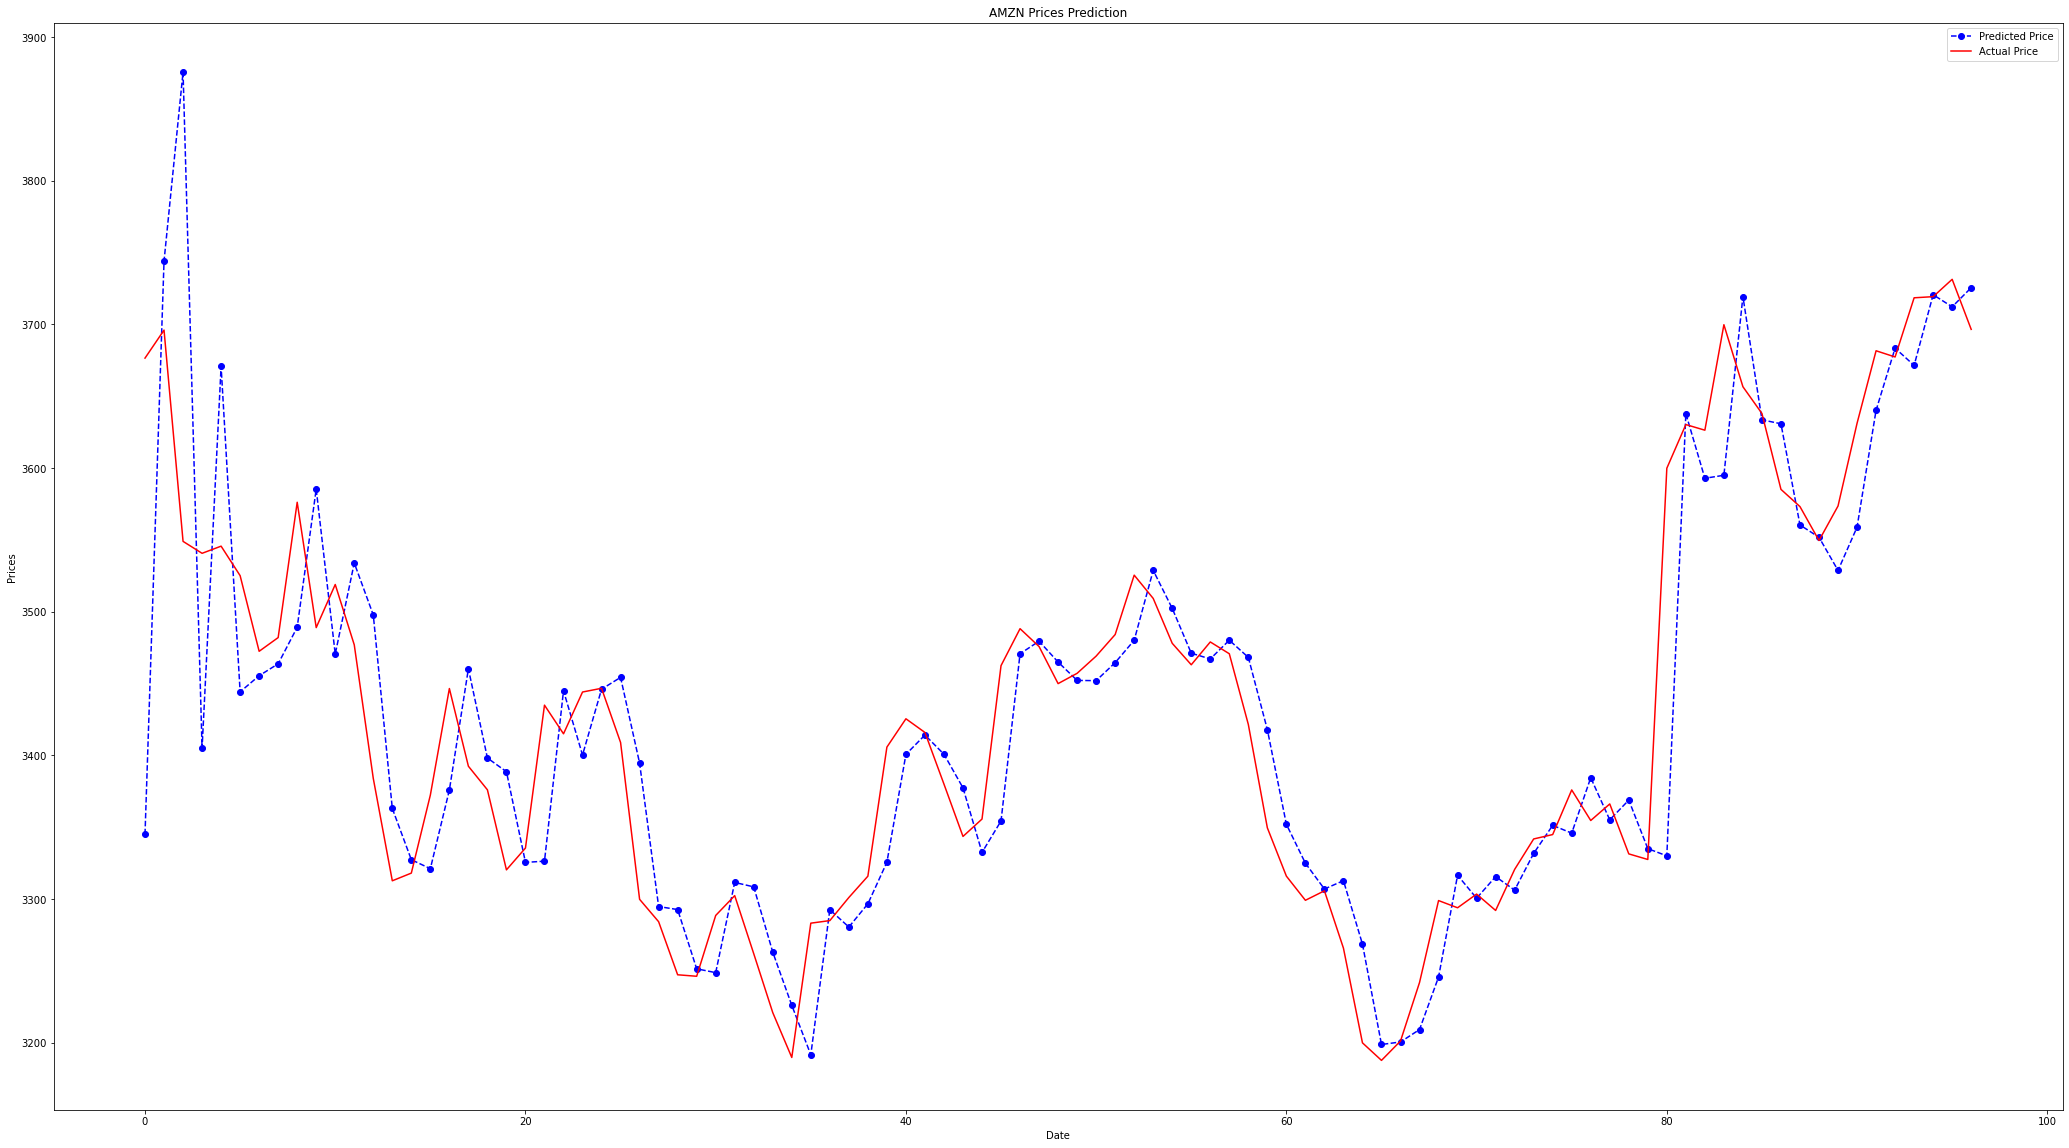

In [311]:
test_range = amzn_df[0:int(len(amzn_df)*.7)].index
plt.plot(test_range, model_predictions, color='blue', marker='o',
        linestyle ='dashed', label='Predicted Price')
plt.plot(test_range, test, color='red', label='Actual Price')
plt.title('AMZN Prices Prediction')
plt.xlabel('Date')
from pylab import rcParams
rcParams['figure.figsize'] = 36, 20
plt.ylabel('Prices')
plt.legend()
plt.show()

# The arima model is likely too slow to implement onto the dashboard, so I will build an xgboost model instead. I will make two general models, one that predicts next day close and one that predicts next 4 hour close.

In [232]:
def build_xgboost_df(symbol):
    """
    IN: symbol : The desired stock symbol to build the xgboost dataframe
    
    OUT: prediction_df : Dataframe that has past 3 day data for a given day with an associated value
    column that is the target variable.
    
    """
    
    prediction_df = pd.DataFrame(columns = ['Close_1day',
                                            'Close_2day',
                                            'Close_3day',
                                            #'Close_4day',
                                            #'Close_5day',
                                            'High_1day',
                                            'High_2day',
                                            'High_3day',
                                            #'High_4day',
                                           #'High_5day',
                                            'Cot_1day',
                                            'Cot_2day',
                                           'Cot_3day',
                                           # 'Cot_4day',
                                            #'Cot_5day',
                                           'Vol_1day',
                                            'Vol_2day',
                                            'Vol_3day',
                                            #'Vol_4day',
                                            #'Vol_5day',
                                            'value',
                                            'Date'
                                       ])
    stock_df = build_time_series_df(symbol)
    prediction_df.value = stock_df.Close[0:(stock_df.shape[0])-5]
    
    prediction_df.Date = stock_df.Date
    
    day_1_close = []
    day_2_close = []
    day_3_close = []
    day_4_close = []
    day_5_close = []

    High_1day = []
    High_2day = []
    High_3day = []
    High_4day = []
    High_5day = []

    Cot_1day = []
    Cot_2day = []
    Cot_3day = []
    Cot_4day= []
    Cot_5day= []

    Vol_1day = []
    Vol_2day = []
    Vol_3day = []
    Vol_4day = []
    Vol_5day = []
    for i in range(len(prediction_df.value)):

        day_1_close.append(stock_df.Close[i+1])
        day_2_close.append(stock_df.Close[i+2])
        day_3_close.append(stock_df.Close[i+3])
#         day_4_close.append(stock_df.Close[i+4])
#         day_5_close.append(stock_df.Close[i+5])

        High_1day.append(stock_df.High[i+1])
        High_2day.append(stock_df.High[i+2])
        High_3day.append(stock_df.High[i+3])
#         High_4day.append(stock_df.High[i+4])
#         High_5day.append(stock_df.High[i+5])

        Cot_1day.append(stock_df['Change Over Time'][i+1])
        Cot_2day.append(stock_df['Change Over Time'][i+2])
        Cot_3day.append(stock_df['Change Over Time'][i+3])
#         Cot_4day.append(stock_df['Change Over Time'][i+4])
#         Cot_5day.append(stock_df['Change Over Time'][i+5])

        Vol_1day.append(stock_df.Volume[i+1])
        Vol_2day.append(stock_df.Volume[i+2])
        Vol_3day.append(stock_df.Volume[i+3])
#         Vol_4day.append(stock_df.Volume[i+4])
#         Vol_5day.append(stock_df.Volume[i+5])

    prediction_df.Close_1day = day_1_close
    prediction_df.Close_2day = day_2_close
    prediction_df.Close_3day = day_3_close
#     prediction_df.Close_4day = day_4_close
#     prediction_df.Close_5day = day_5_close

    prediction_df.High_1day = High_1day
    prediction_df.High_2day= High_2day
    prediction_df.High_3day= High_3day
#     prediction_df.High_4day= High_4day
#     prediction_df.High_5day= High_5day

    prediction_df.Cot_1day = Cot_1day
    prediction_df.Cot_2day = Cot_2day
    prediction_df.Cot_3day = Cot_3day
#     prediction_df.Cot_4day = Cot_4day
#     prediction_df.Cot_5day = Cot_5day

    prediction_df.Vol_1day = Vol_1day
    prediction_df.Vol_2day = Vol_2day
    prediction_df.Vol_3day = Vol_3day
#     prediction_df.Vol_4day = Vol_4day
#     prediction_df.Vol_5day = Vol_5day

    prediction_df['News_Sentiment_1day'] = None
    news_df = vader_sentiment_analysis(apikey, symbol)
    prediction_df.News_Sentiment_1day = prediction_df.Date.apply(
        lambda dat: np.mean(trim_news_dates(str(dat), news_df).CompoundAvg))

    
    
    return prediction_df

In [312]:
prediction_df = build_xgboost_df('AMZN')
prediction_df.tail()

,Close_1day,Close_2day,Close_3day,High_1day,High_2day,High_3day,Cot_1day,Cot_2day,Cot_3day,Vol_1day,Vol_2day,Vol_3day,value,Date,News_Sentiment_1day
129,3232.28,3270.39,3222.90,3312.00,3292.75,3228.86,-0.01831,0.00754,0.01172,2848603.0,3725056.0,3326646.0,3231.80,2021-05-19,0.206208
130,3270.39,3222.90,3161.47,3292.75,3228.86,3203.00,0.00754,0.01172,-0.00753,3725056.0,3326646.0,3377729.0,3232.28,2021-05-18,0.198127
131,3222.90,3161.47,3151.94,3228.86,3203.00,3207.94,0.01172,-0.00753,-0.01038,3326646.0,3377729.0,4750255.0,3270.39,2021-05-17,0.214296
132,3161.47,3151.94,3223.91,3203.00,3207.94,3237.72,-0.00753,-0.01038,0.02794,3377729.0,4750255.0,4627636.0,3222.90,2021-05-14,0.235935
133,3151.94,3223.91,3190.49,3207.94,3237.72,3283.00,-0.01038,0.02794,-0.02798,4750255.0,4627636.0,5888386.0,3161.47,2021-05-13,0.340608


In [313]:
test_data, train_data = prediction_df[0:int(len(prediction_df)*.07)], \
                            prediction_df[int(len(prediction_df)*.07):]

#### - Plot data in the following format:
- 3 distinct lines separated by color
- plot y_train
- plot y_test
- plot y_preds

In [314]:
X_test = test_data.drop(columns = ['Date', 'value'])
#X_test_scaled = pd.DataFrame(sc.transform(X_test), columns = X_test.columns)
y_train = train_data.value
X_train = train_data.drop(columns = ['Date', 'value'])

y_test = test_data.value

In [315]:
xg = GradientBoostingRegressor()
xg.fit(X_train, y_train)
y_pred = pd.Series(xg.predict(X_test))

In [316]:
xgboost_prediction_df = pd.DataFrame(columns = ['value', 'data_category', 'Date'])
combined_list = pd.concat([y_test, y_train, y_pred])
combined_list.reset_index(drop = True, inplace = True)

xgboost_prediction_df.value = combined_list
xgboost_prediction_df.Date = prediction_df.Date



test_cutoff = len(y_test)
pred_cutoff = len(y_test) + len(y_train)
counter = 0
for i in range(len(combined_list)):
    if (counter > test_cutoff)&(counter < pred_cutoff):
        xgboost_prediction_df.data_category[i] = 'train'
    elif (counter <= test_cutoff):
        xgboost_prediction_df.data_category[i] = 'test'
    elif (counter >= pred_cutoff):
        xgboost_prediction_df.data_category[i] = 'pred'
    counter += 1
        
pred_dates = xgboost_prediction_df.iloc[:len(y_test)].Date
count = 0
i = 0
for date in xgboost_prediction_df.Date:
    if str(date)[0] == 'N':
        xgboost_prediction_df.Date[count] = pred_dates[i]
        i += 1
    count += 1

In [317]:
xg_df, xg, pred_df, apple_mae = build_general_model_daily_prediction_df('AMZN')

In [294]:
def build_general_model_daily_prediction_df(stock):
    """
    IN: stock : Stock Symbol
    
    OUT: 
        xgboost_prediction_df: Dataframe containing train, test, and prediction 
    results
        xg: Model used for prediction
        prediction_df : Dataframe used to train and test model
        mae : Mean Absolue Error of model from test results
          
    """
    prediction_df = build_xgboost_df(stock)

    test_data, train_data = prediction_df[0:int(len(prediction_df)*.1)], \
                            prediction_df[int(len(prediction_df)*.1):]
    
    X_test = test_data.drop(columns = ['Date', 'value'])

    y_train = train_data.value
    X_train = train_data.drop(columns = ['Date', 'value'])
    y_test = test_data.value

    xg = GradientBoostingRegressor()
    xg.fit(X_train, y_train)
    y_pred = pd.Series(xg.predict(X_test))
    mae = np.sqrt(mean_squared_error(y_test, y_pred))
    
    xgboost_prediction_df = pd.DataFrame(columns = ['value', 'data_category', 'Date'])
    combined_list = pd.concat([y_test, y_train, y_pred])
    combined_list.reset_index(drop = True, inplace = True)

    xgboost_prediction_df.value = combined_list
    xgboost_prediction_df.Date = prediction_df.Date



    test_cutoff = len(y_test)
    pred_cutoff = len(y_test) + len(y_train)
    counter = 0
    for i in range(len(combined_list)):
        if (counter > test_cutoff)&(counter < pred_cutoff):
            xgboost_prediction_df.data_category[i] = 'train'
        elif (counter <= test_cutoff):
            xgboost_prediction_df.data_category[i] = 'test'
        elif (counter >= pred_cutoff):
            xgboost_prediction_df.data_category[i] = 'pred'
        counter += 1
            
    pred_dates = xgboost_prediction_df.iloc[:len(y_test)].Date
    count = 0
    i = 0
    for date in xgboost_prediction_df.Date:
        if str(date)[0] == 'N':
            xgboost_prediction_df.Date[count] = pred_dates[i]
            i += 1
        count += 1
        
    
    return xgboost_prediction_df, xg, prediction_df, mae

In [89]:
float(mean_absolute_error(y_test, y_pred))

62.989470167693376

In [90]:
fig = px.line(xgboost_prediction_df, x='Date', y='value', color='data_category', markers=True)
fig.show()

In [99]:
tomorrow_tsla_close_price = make_tomorrow_pred('AMZN', prediction_df, xg)

In [100]:
tomorrow_tsla_close_price

array([3676.66472585])

In [ ]:
tomorrow_tsla_close_price

In [29]:
trim_news_dates('2021-11-22' ,a)

,Date,Title,Text,CompoundScoreTitle,PositiveScoreTitle,NegativeScoreTitle,CompoundScoreText,NeutralScoreTitle,NeutralScoreText,textLeans,titleLeans,PositiveScoreText,NegativeScoreText,CompoundAvg,Symbol,weekday,time
0,2021-11-22 07:15:00,Warren Buffett Loves These Stocks: Are They Ri...,It depends on if a personal preference for a p...,0.5719,0.291,0.0,0.0,0.709,1.0,Neutral,Positive,0.0,0.0,0.28595,AAPL,0,07:15:00


In [96]:
a = vader_sentiment_analysis(apikey, 'AMZN', 20)
    
b = np.mean(trim_news_dates(datetime.today().strftime('%Y-%m-%d'), a).CompoundAvg)

In [97]:
b

0.2979

In [239]:
def make_tomorrow_pred(stock, series, model):
    """
    IN: 
        stock: Stock symbol
        series : Dataframe prediction_df returned from build_general_model_daily_prediction_df
        model: Model retured From build_general_model_daily_prediction_df
    OUT:
        pred : Prediction for next stock day
    
    """
    cols = ['close_1day', 'close_2day','close_3day', 'high_1day',
              'high_2day', 'high_3day', 'cot_1day', 'cot_2day',
              'cot_3day', 'vol_1day', 'vol_2day', 'vol_3day', 'news_sent1day']
    X = pd.DataFrame(columns = cols)
    yesterday_data = fmpsdk.historical_price_full(apikey, stock)['historical'][0]
    
    a = vader_sentiment_analysis(apikey, stock, 20)
    
    X.news_sent1day = pd.Series(np.mean(trim_news_dates(datetime.today().strftime('%Y-%m-%d'), a).CompoundAvg))

    X.close_1day = pd.Series(yesterday_data['close'])
    X.close_2day = pd.Series(series.Close_1day[0])
    X.close_3day = pd.Series(series.Close_2day[0])

    X.high_1day = pd.Series(yesterday_data['high'])
    X.high_2day = pd.Series(series.High_1day[0])
    X.high_3day = pd.Series(series.High_2day[0])

    X.cot_1day = pd.Series(yesterday_data['changeOverTime'])
    X.cot_2day = pd.Series(series.Cot_1day[0])
    X.cot_3day = pd.Series(series.Cot_2day[0])

    X.vol_1day = pd.Series(yesterday_data['volume'])
    X.vol_2day = pd.Series(series.Vol_1day[0])
    X.vol_3day = pd.Series(series.Vol_2day[0])

    pred = model.predict(X)
    
    return pred

#### Feature Importances

In [318]:
xg_df, xg, pred_df, mae = build_general_model_daily_prediction_df('AAPL')

In [283]:
importance_df = pd.DataFrame(xg.feature_importances_, columns=['importance'])
importance_df['feature_name'] = prediction_df.drop(columns=['Date', 'value']).columns

In [288]:
importance_df.sort_values('importance', ascending=False, ignore_index=True)

,importance,feature_name
0,0.472796,Close_1day
1,0.293361,Close_3day
2,0.148589,Close_2day
3,0.049592,High_1day
4,0.012810,High_2day
5,0.004726,Cot_3day
6,0.004395,High_3day
7,0.003072,Vol_3day
8,0.002869,Cot_1day
9,0.002842,Vol_1day


<AxesSubplot:>

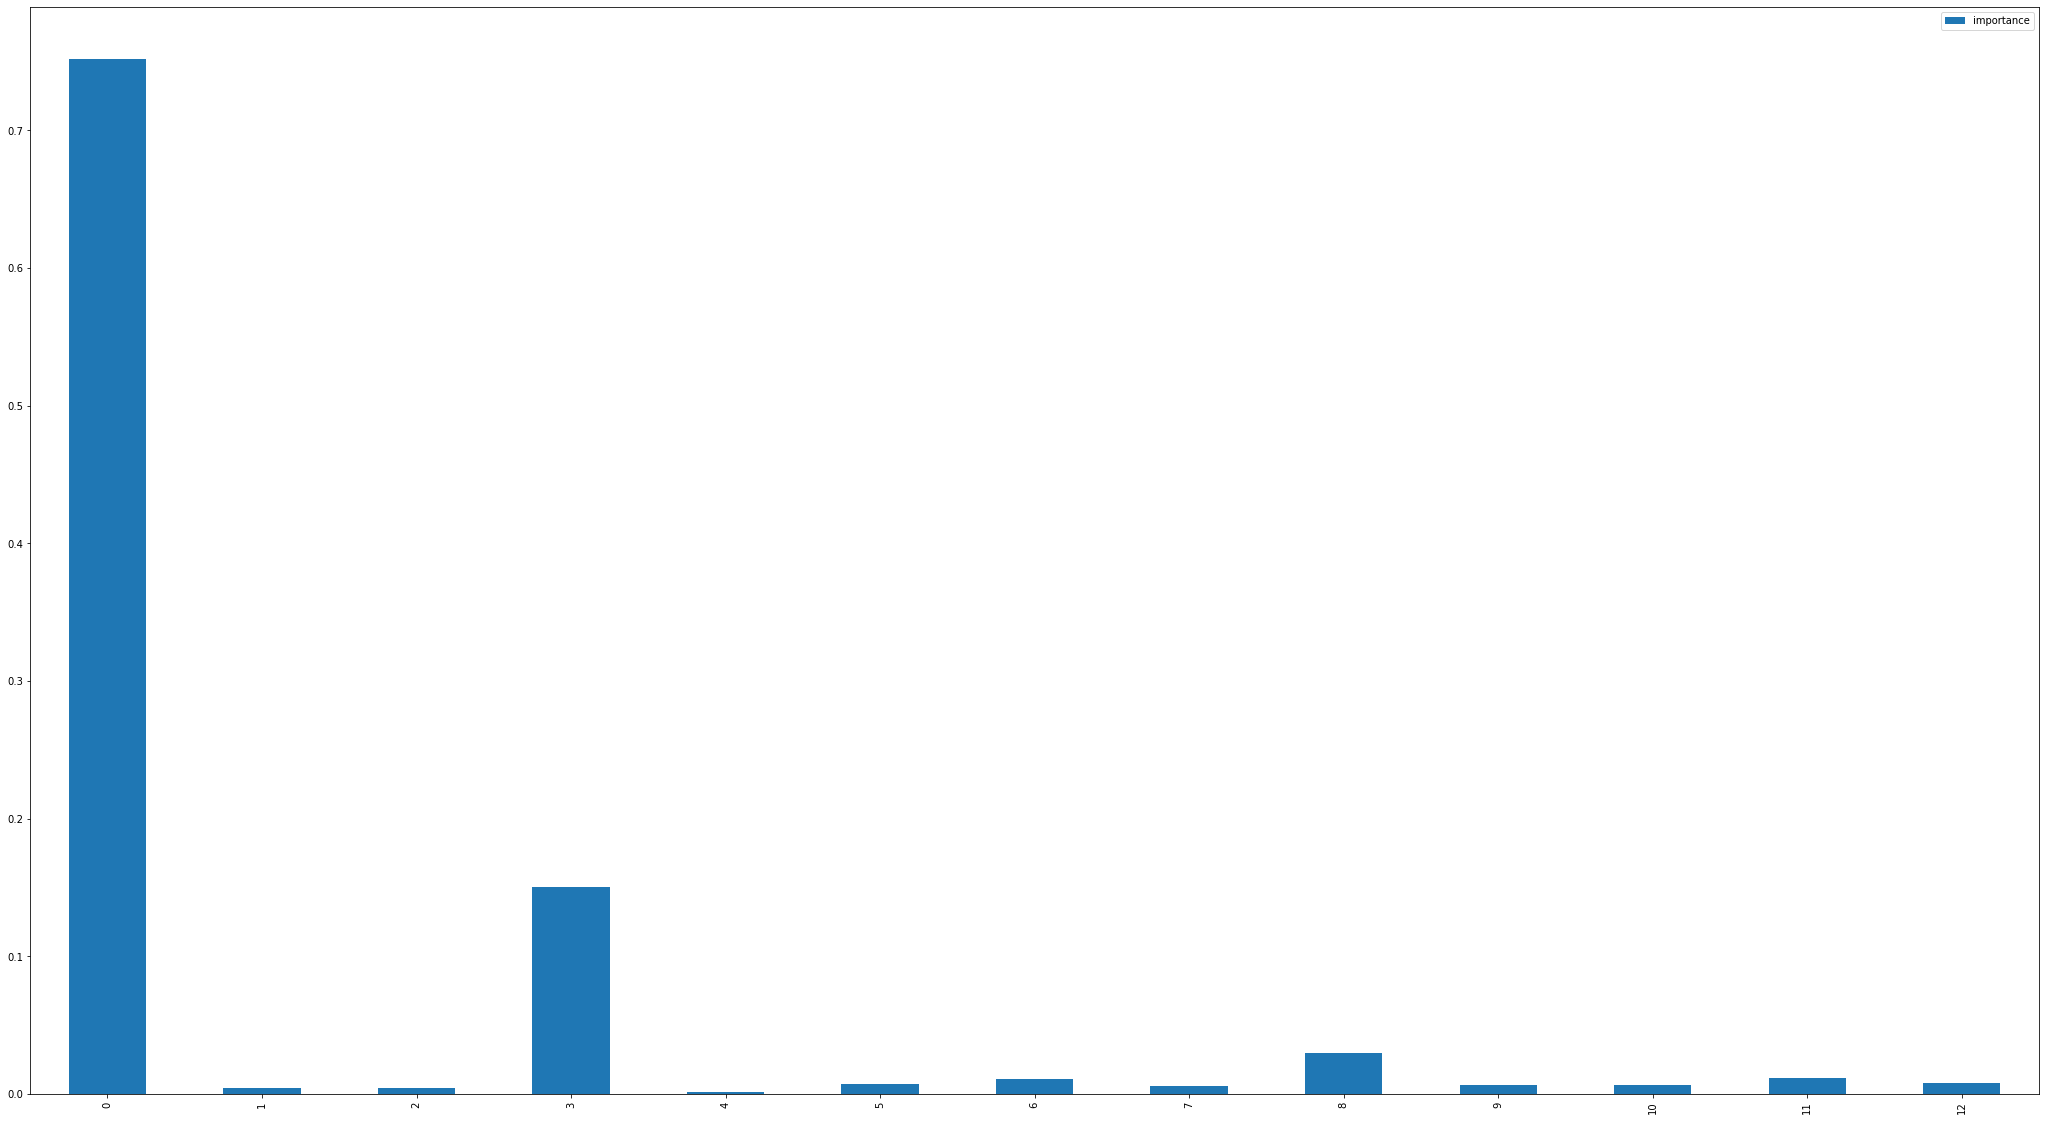

In [115]:
importance_df.plot(kind='bar')

In [ ]:
fig = px.line(xg_df, x='Date', y='value', color='data_category', markers=True,
             title = 'NEXT Day Prediction: '+str(make_tomorrow_pred('MSFT', prediction_df, xg)) \
                                                +" +/- "+str(mae))
fig.show()

#### Unsurprisingly, the closing price of the previous day is the biggest predictor. Going forward, I am going to investigate how much public news sentiment can help this model.

In [18]:
def vader_sentiment_analysis(apikey, ticker, limit=5000):
    """
    IN: 
    apikey: This should be your personalized api key. You can get one here 
    (https://fmpcloud.io/)

    ticker: This is the stock symbol as or trade name. e.g. TSLA, AAPL, GOOG

    limit: This number references how far back in date you want to go. If you
    want to find the date range please use get_timeframe() on this method's returned df.
    
    OUT: Pandas Dataframe
    """
    #Initialize the sentiment analyzer
    sid = SentimentIntensityAnalyzer()
    #Collect the data from the fmpsdk api
    news = fmpsdk.stock_news(apikey=apikey, tickers=ticker, limit=limit)
    #Construct the dataframe with predtermined columns
    df = pd.DataFrame(columns=['Date', 'Title', 'Text', 'CompoundScoreTitle',
                          'PositiveScoreTitle', 'NegativeScoreTitle', 
                          'CompoundScoreText', 'NeutralScoreTitle',
                           'NeutralScoreText', 'textLeans', 'titleLeans',
                          'PositiveScoreText', 'NegativeScoreText',
                          'CompoundAvg', 'Symbol'])
    
    dates = []
    titles = []
    text_ = []
    symbols = []


    #Loops through the news variable which contains the data from the api. For 
    #loop the lists dates, titles, & text_ get appended so that the df above can
    #then have three columns with data
    for article in news:
        dates.append(article['publishedDate'])
        titles.append(article['title'])
        text_.append(article['text']) 
        symbols.append(article['symbol'])
    df.Date = pd.to_datetime(dates)
    df.Title = titles
    df.Text = text_
    df.Symbol = symbols
    
    #Removes None values from text that can appear
    df.Text = df.Text.apply(lambda txt: txt if txt != None else('Blank'))
    #Scores the title of the articles using compound score
    df.CompoundScoreTitle = df.Title.apply(lambda title:
    sid.polarity_scores(title)['compound'])
    #Scores the title of the articles using positive score
    df.PositiveScoreTitle = df.Title.apply(lambda title:
        sid.polarity_scores(title)['pos'])
    #Scores the title of the articles using negative score
    df.NegativeScoreTitle = df.Title.apply(lambda title:
        sid.polarity_scores(title)['neg'])
    #Scores the title of the articles using neutral score
    df.NeutralScoreTitle = df.Title.apply(lambda title:
        sid.polarity_scores(title)['neu'])
    #Scores the text of the articles using compound score
    df.CompoundScoreText = df.Text.apply(lambda text:
        sid.polarity_scores(text)['compound'])
    #Scores the text of the articles using positive score
    df.PositiveScoreText = df.Text.apply(lambda text:
        sid.polarity_scores(text)['pos'])
    #Scores the text of the articles using negative score
    df.NegativeScoreText = df.Text.apply(lambda text:
        sid.polarity_scores(text)['neg'])
    #Scores the text of the articles using neutral score
    df.NeutralScoreText = df.Text.apply(lambda text:
        sid.polarity_scores(text)['neu'])
    
    #I will now add two columns to the dataframe that will tell me which way the
    #sentiment analyzer is leaning in regards to tile and text. I will be using
    #the comound score here because it is the best representation of positve/neutral
    #& negative scores.

    #If the title comound score is less than 0 I determine that the title leans negative
    #if the comound score is greater than 0 I dettermine that the title leans
    #positive. Otherwise neutral.
    df.titleLeans = df.CompoundScoreTitle.apply(lambda score:
                    'Negative' if score < 0 
                     else('Positive' if score > 0
                          else('Neutral')))
                        
    df.textLeans = df.CompoundScoreText.apply(lambda score:
                        'Negative' if score < 0 
                         else('Positive' if score > 0
                              else('Neutral')))
    #Now I will add the day of the week
    #Days of the week are numberd 0-6 where 0 is Monday
    df['weekday'] = df.Date.apply(lambda date:
                                  date.weekday())
    #The time corresponding with the date will also need to in it's own column
    #for later processing
    df['time'] = df.Date.apply(lambda date:
                               date.time())
    #Finally I add the average of the comound scores for the title and text of a 
    #given article
    df.CompoundAvg = (df.CompoundScoreTitle + df.CompoundScoreText)/2
    
    return df

In [289]:
df = vader_sentiment_analysis(apikey, 'MSFT')

In [ ]:
df.head(3)

#### Now, I need to implement sentiment scores into already developed time series dataframe that I have developed. Each day should receive a general sentiment. What I will do is if add three columns one_day news sentiment, two_day news sentiment, and three_day news sentiment. These columns will contain the compund average score of all the compound average scores of the news titles/artiles for the day.

In [28]:
def trim_news_dates(stock_prediction_day, df):
  """
  This function will trim a provided dataframe to only contain dates relevant to
  the stock_prediction_day.

  IN: 
   - stock_prediction_day: This is the date that one would like to predict a 
   stocks gain/loss should be a string in the form 'YYYY-MM-DD'
   - df: This is the data frame that will be trimmed and returned only contaning
   dates relavant to the prediction
  """

  #Set start_cutoff to one day before stock_prediction_day at 4:00 PM as
  #a pandas datetime object
  end_cutoff = pd.to_datetime(stock_prediction_day + ' 16:00:00')
  start_cutoff = end_cutoff - timedelta(days=1)
  
  return df.loc[(df.Date >= start_cutoff) &
       (df.Date <= end_cutoff)]

In [27]:
def determine_date_range(df):
  """
  IN: pandas data frame that you would like to know the date range of
  OUT: Date range in pandas.datetime format
  """
  end_date = df.Date[0]
  start_date = df.Date[df.shape[0]-1]
  return (start_date, end_date)

In [290]:
trimmed_df = trim_news_dates('2021-11-22', df)

In [ ]:
np.mean(trimmed_df.CompoundAvg)

#### The Plan:
- Add a clause into the build build_general_model_daily_prediction_df(stock) that will add the mean Compound AvG score for the prior stock day.

In [319]:
prediction_df = build_xgboost_df('AAPL')


In [320]:
prediction_df['News_Sentiment_1day'] = None

In [321]:
df = vader_sentiment_analysis(apikey, 'AAPL')

In [322]:
determine_date_range(df)

(Timestamp('2020-10-21 16:23:29'), Timestamp('2021-11-22 14:07:51'))

In [323]:
prediction_df.News_Sentiment_1day = prediction_df.Date.apply(
    lambda dat: np.mean(trim_news_dates(str(dat), df).CompoundAvg))

In [324]:
prediction_df.tail()

,Close_1day,Close_2day,Close_3day,High_1day,High_2day,High_3day,Cot_1day,Cot_2day,Cot_3day,Vol_1day,Vol_2day,Vol_3day,value,Date,News_Sentiment_1day
129,124.849998,126.269997,127.449997,126.989998,126.930000,127.889999,-0.01351,-0.00434,0.00950,63342900.0,74244600.0,81918000.0,124.690002,2021-05-19,0.215179
130,126.269997,127.449997,124.970001,126.930000,127.889999,126.150002,-0.00434,0.00950,0.00313,74244600.0,81918000.0,105861300.0,124.849998,2021-05-18,0.022045
131,127.449997,124.970001,122.769997,127.889999,126.150002,124.639999,0.00950,0.00313,-0.00511,81918000.0,105861300.0,112172300.0,126.269997,2021-05-17,0.009027
132,124.970001,122.769997,125.910004,126.150002,124.639999,126.269997,0.00313,-0.00511,0.01951,105861300.0,112172300.0,126142800.0,127.449997,2021-05-14,0.159123
133,122.769997,125.910004,126.849998,124.639999,126.269997,129.539993,-0.00511,0.01951,-0.01978,112172300.0,126142800.0,88071200.0,124.970001,2021-05-13,0.083511


#### Now, I can make additional predictions.

In [325]:
test_data, train_data = prediction_df[0:int(len(prediction_df)*.1)], \
                        prediction_df[int(len(prediction_df)*.1):]

X_test = test_data.drop(columns = ['Date', 'value'])

y_train = train_data.value
X_train = train_data.drop(columns = ['Date', 'value'])
y_test = test_data.value

xg = GradientBoostingRegressor()
xg.fit(X_train, y_train)
y_pred = pd.Series(xg.predict(X_test))
mae = np.sqrt(mean_squared_error(y_test, y_pred))

xgboost_prediction_df = pd.DataFrame(columns = ['value', 'data_category', 'Date'])
combined_list = pd.concat([y_test, y_train, y_pred])
combined_list.reset_index(drop = True, inplace = True)

xgboost_prediction_df.value = combined_list
xgboost_prediction_df.Date = prediction_df.Date



test_cutoff = len(y_test)
pred_cutoff = len(y_test) + len(y_train)
counter = 0
for i in range(len(combined_list)):
    if (counter > test_cutoff)&(counter < pred_cutoff):
        xgboost_prediction_df.data_category[i] = 'train'
    elif (counter <= test_cutoff):
        xgboost_prediction_df.data_category[i] = 'test'
    elif (counter >= pred_cutoff):
        xgboost_prediction_df.data_category[i] = 'pred'
    counter += 1

pred_dates = xgboost_prediction_df.iloc[:len(y_test)].Date
count = 0
i = 0
for date in xgboost_prediction_df.Date:
    if str(date)[0] == 'N':
        xgboost_prediction_df.Date[count] = pred_dates[i]
        i += 1
        count += 1

In [326]:
count = 0
i = 0
for date in xgboost_prediction_df.Date:
    if str(date)[0] == 'N':
        xgboost_prediction_df.Date[count] = pred_dates[i]
        i += 1
    count += 1

In [53]:
xgboost_prediction_df

,value,data_category,Date
0,160.550000,test,2021-11-19
1,157.870000,test,2021-11-18
2,153.490000,test,2021-11-17
3,151.000000,test,2021-11-16
4,150.000000,test,2021-11-15
...,...,...,...
142,148.913872,pred,2021-11-09
143,150.334607,pred,2021-11-08
144,149.555132,pred,2021-11-05
145,151.931868,pred,2021-11-04


In [118]:
fig = px.line(xgboost_prediction_df, x='Date', y='value', color='data_category', markers=True,
             title = 'NEXT Day Prediction: '+str(make_tomorrow_pred('AAPL', prediction_df, xg)) \
                                                +" +/- "+str(mae))
fig.show()

In [55]:
mae

2.8668459917018927

In [57]:
apple_mae

2.7422727997016776

#### Now, that I have added news sentiment I will compare models and explore results. I want to investigate if the news sentiment is helping the model.

In [327]:
xg_df, xg, pred_df, mae = build_general_model_daily_prediction_df('AAPL')

In [117]:
mae

2.768970979145723

In [126]:
fig = px.line(xg_df, x='Date', y='value', color='data_category', markers=True,
             title = 'WITH NEWS SENTIMENT NEXT Day Prediction For AAPL: '+str(make_tomorrow_pred('AAPL', pred_df, xg)) \
                                                +" +/- "+str(mae))
fig.show()

In [128]:
fig = px.line(xg_df, x='Date', y='value', color='data_category', markers=True,
             title = 'WITHOUT NEWS SENTIMENT NEXT Day Prediction For AAPL: '+str(make_tomorrow_pred('AAPL', pred_df, xg)) \
                                                +" +/- "+str(mae))
fig.show()

In [328]:
amzn_df = build_time_series_df('AAPL')
test_data, train_data = amzn_df[0:int(len(amzn_df)*.7)], \
                            amzn_df[int(len(amzn_df)*.7):]

train = train_data['Close'].values
test = test_data['Close'].values
# Create list of x train valuess
history = [x for x in train]
# establish list for predictions
model_predictions = []
# Count number of test data points
N_test_observations = len(test)
# loop through every data point
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(5,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test[time_point]
    history.append(true_test_value)
MAE_error = mean_absolute_error(test, model_predictions).numpy()
print('Testing Mean Absolute Error is {}'.format(MAE_error))


Testing Mean Absolute Error is 2.2021835932969793


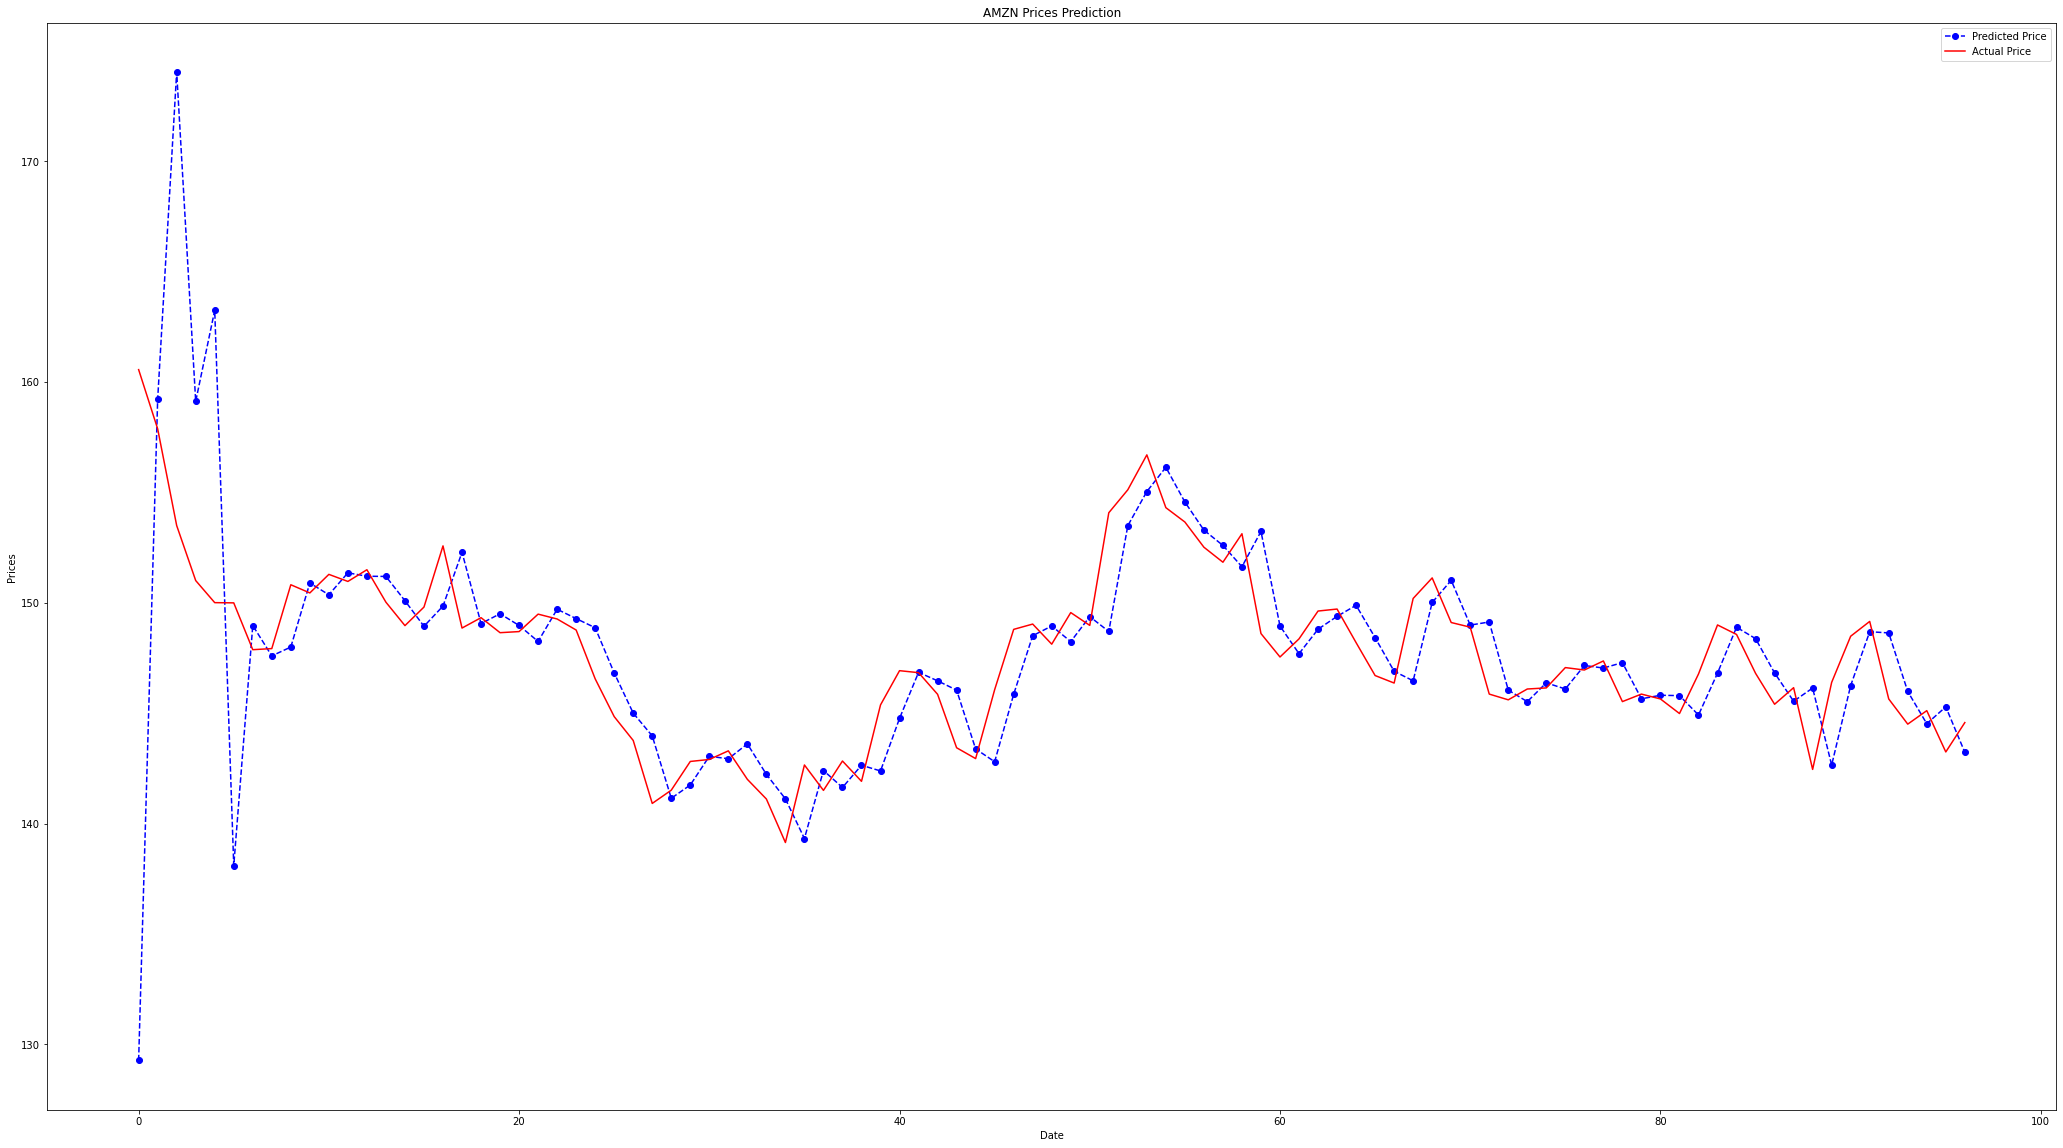

In [132]:
test_range = amzn_df[0:int(len(amzn_df)*.7)].index
plt.plot(test_range, model_predictions, color='blue', marker='o',
        linestyle ='dashed', label='Predicted Price')
plt.plot(test_range, test, color='red', label='Actual Price')
plt.title('AMZN Prices Prediction')
plt.xlabel('Date')
from pylab import rcParams
rcParams['figure.figsize'] = 36, 20
plt.ylabel('Prices')
plt.legend()
plt.show()

#### Now, I will develop an XGBOOST model the same way except this time it will predict the next close price in a 1 hour window.

In [141]:
hourly_stock = fmpsdk.historical_chart(apikey, 'AAPL', "1hour")

In [149]:
hourly_stock[0]['date']

'2021-11-22 11:00:00'

In [151]:
hourly_df = pd.DataFrame(columns = ['Time', 'Close', 'High', 'Volume', 'Low'])
opens = []
times = []
closes = []
highs = []
volumes = []
lows = []
for hour in hourly_stock:
    times.append(hour['date'])
    opens.append(hour['open'])
    closes.append(hour['close'])
    highs.append(hour['high'])
    volumes.append(hour['volume'])
    lows.append(hour['low'])

hourly_df.Time = times
hourly_df.Close = closes
hourly_df.High = highs
hourly_df.Volume = volumes
hourly_df.Low = lows

In [152]:
hourly_df.head()

,Time,Close,High,Volume,Low
0,2021-11-22 11:00:00,164.5399,165.22,14101069,163.97
1,2021-11-22 10:00:00,164.7425,165.70,27040963,164.52
2,2021-11-19 16:00:00,160.7500,160.86,5261272,160.52
3,2021-11-19 15:00:00,160.5600,161.02,18657833,160.10
4,2021-11-19 14:00:00,160.5150,160.84,10171246,160.30


In [247]:
def build_time_series_hourly_df(symbol):

    hourly_stock = fmpsdk.historical_chart(apikey, symbol, "1hour")
    
    hourly_df = pd.DataFrame(columns = ['Time', 'Close', 'High', 'Volume', 'Low'])
    opens = []
    times = []
    closes = []
    highs = []
    volumes = []
    lows = []
    for hour in hourly_stock:
        times.append(hour['date'])
        opens.append(hour['open'])
        closes.append(hour['close'])
        highs.append(hour['high'])
        volumes.append(hour['volume'])
        lows.append(hour['low'])

    hourly_df.Time = times
    hourly_df.Close = closes
    hourly_df.High = highs
    hourly_df.Volume = volumes
    hourly_df.Low = lows

 
    return hourly_df


#### Now, I just need to remake the xg_df

In [160]:
def build_xgboost_hourly_df(symbol):
    
    prediction_df = pd.DataFrame(columns = ['Close_1hour',
                                            'Close_2hour',
                                            'Close_3hour',
                                            #'Close_4day',
                                            #'Close_5day',
                                            'High_1hour',
                                            'High_2hour',
                                            'High_3hour',
                                            #'High_4day',
                                           #'High_5day',
                                            'Low_1hour',
                                            'Low_2hour',
                                           'Low_3hour',
                                           # 'Cot_4day',
                                            #'Cot_5day',
                                           'Vol_1hour',
                                            'Vol_2hour',
                                            'Vol_3hour',
                                            #'Vol_4day',
                                            #'Vol_5day',
                                            'value',
                                            'Time'
                                       ])
    stock_df = build_time_series_hourly_df(symbol)
    prediction_df.value = stock_df.Close[0:(stock_df.shape[0])-5]
    prediction_df.Time = stock_df.Time
    day_1_close = []
    day_2_close = []
    day_3_close = []
    day_4_close = []
    day_5_close = []

    High_1day = []
    High_2day = []
    High_3day = []
    High_4day = []
    High_5day = []

    Low_1day = []
    Low_2day = []
    Low_3day = []
    Low_4day= []
    Low_5day= []

    Vol_1day = []
    Vol_2day = []
    Vol_3day = []
    Vol_4day = []
    Vol_5day = []
    for i in range(len(prediction_df.value)):

        day_1_close.append(stock_df.Close[i+1])
        day_2_close.append(stock_df.Close[i+2])
        day_3_close.append(stock_df.Close[i+3])
#         day_4_close.append(stock_df.Close[i+4])
#         day_5_close.append(stock_df.Close[i+5])

        High_1day.append(stock_df.High[i+1])
        High_2day.append(stock_df.High[i+2])
        High_3day.append(stock_df.High[i+3])
#         High_4day.append(stock_df.High[i+4])
#         High_5day.append(stock_df.High[i+5])

        Low_1day.append(stock_df['Low'][i+1])
        Low_2day.append(stock_df['Low'][i+2])
        Low_3day.append(stock_df['Low'][i+3])
#         Cot_4day.append(stock_df['Change Over Time'][i+4])
#         Cot_5day.append(stock_df['Change Over Time'][i+5])

        Vol_1day.append(stock_df.Volume[i+1])
        Vol_2day.append(stock_df.Volume[i+2])
        Vol_3day.append(stock_df.Volume[i+3])
#         Vol_4day.append(stock_df.Volume[i+4])
#         Vol_5day.append(stock_df.Volume[i+5])

    prediction_df.Close_1hour = day_1_close
    prediction_df.Close_2hour = day_2_close
    prediction_df.Close_3hour = day_3_close
#     prediction_df.Close_4day = day_4_close
#     prediction_df.Close_5day = day_5_close

    prediction_df.High_1hour = High_1day
    prediction_df.High_2hour = High_2day
    prediction_df.High_3hour = High_3day
#     prediction_df.High_4day= High_4day
#     prediction_df.High_5day= High_5day

    prediction_df.Low_1hour = Low_1day
    prediction_df.Low_2hour = Low_2day
    prediction_df.Low_3hour = Low_3day
#     prediction_df.Cot_4day = Cot_4day
#     prediction_df.Cot_5day = Cot_5day

    prediction_df.Vol_1hour = Vol_1day
    prediction_df.Vol_2hour = Vol_2day
    prediction_df.Vol_3hour = Vol_3day
#     prediction_df.Vol_4day = Vol_4day
#     prediction_df.Vol_5day = Vol_5day

        
    return prediction_df

In [161]:
pred_hourly_df = build_xgboost_hourly_df('AAPL')

In [162]:
pred_hourly_df.head(1)

,Close_1hour,Close_2hour,Close_3hour,High_1hour,High_2hour,High_3hour,Low_1hour,Low_2hour,Low_3hour,Vol_1hour,Vol_2hour,Vol_3hour,value,Time
0,163.54,164.7425,160.75,165.22,165.7,160.86,163.04,164.52,160.52,17723143,27040963,5261272,163.7513,2021-11-22 12:00:00


#### Now, I can make prediction and evaluate the model

In [206]:
def build_general_model_hourly_prediction_df(stock):
    prediction_df = build_xgboost_hourly_df(stock)

    test_data, train_data = prediction_df[0:int(len(prediction_df)*.025)], \
                            prediction_df[int(len(prediction_df)*.025):]
    
    X_test = test_data.drop(columns = ['Time', 'value'])

    y_train = train_data.value
    X_train = train_data.drop(columns = ['Time', 'value'])
    y_test = test_data.value

    xg = GradientBoostingRegressor()
    xg.fit(X_train, y_train)
    y_pred = pd.Series(xg.predict(X_test))
    mae = np.sqrt(mean_squared_error(y_test, y_pred))
    
    xgboost_prediction_df = pd.DataFrame(columns = ['value', 'data_category', 'Time'])
    combined_list = pd.concat([y_test, y_train, y_pred])
    combined_list.reset_index(drop = True, inplace = True)

    xgboost_prediction_df.value = combined_list
    xgboost_prediction_df.Time = prediction_df.Time



    test_cutoff = len(y_test)
    pred_cutoff = len(y_test) + len(y_train)
    counter = 0
    for i in range(len(combined_list)):
        if (counter > test_cutoff)&(counter < pred_cutoff):
            xgboost_prediction_df.data_category[i] = 'train'
        elif (counter <= test_cutoff):
            xgboost_prediction_df.data_category[i] = 'test'
        elif (counter >= pred_cutoff):
            xgboost_prediction_df.data_category[i] = 'pred'
        counter += 1
            
    pred_dates = list(xgboost_prediction_df.iloc[:len(y_test)].Time)
    count = 0
    i = 0
    for date in xgboost_prediction_df.Time:
        if date is np.nan:
            xgboost_prediction_df.Time[count] = pred_dates[i]
            i += 1
        count += 1
        
    #return pred_dates, xgboost_prediction_df
    return xgboost_prediction_df, xg, prediction_df, mae

In [329]:
xg_hourly_df, xg_hourly_model, prediction_hourly_df, hourly_mae = build_general_model_hourly_prediction_df('AAPL')

In [210]:
prediction_hourly_df

,Close_1hour,Close_2hour,Close_3hour,High_1hour,High_2hour,High_3hour,Low_1hour,Low_2hour,Low_3hour,Vol_1hour,Vol_2hour,Vol_3hour,value,Time
0,163.5400,164.7425,160.7500,165.22,165.7000,160.8600,163.0400,164.5200,160.520,17723143,27040963,5261272,163.3899,2021-11-22 12:00:00
1,164.7425,160.7500,160.5600,165.70,160.8600,161.0200,164.5200,160.5200,160.100,27040963,5261272,18657833,163.5400,2021-11-22 11:00:00
2,160.7500,160.5600,160.5150,160.86,161.0200,160.8400,160.5200,160.1000,160.300,5261272,18657833,10171246,164.7425,2021-11-22 10:00:00
3,160.5600,160.5150,160.6900,161.02,160.8400,160.7200,160.1000,160.3000,159.770,18657833,10171246,11925549,160.7500,2021-11-19 16:00:00
4,160.5150,160.6900,160.2866,160.84,160.7200,160.3500,160.3000,159.7700,159.690,10171246,11925549,10378119,160.5600,2021-11-19 15:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,142.1100,142.6300,142.9500,143.11,143.4600,143.0600,141.9000,142.5035,142.800,11059012,11465157,1129136,141.7799,2021-09-30 12:00:00
260,142.6300,142.9500,142.8400,143.46,143.0600,144.0100,142.5035,142.8000,142.510,11465157,1129136,10730132,142.1100,2021-09-30 11:00:00
261,142.9500,142.8400,143.9445,143.06,144.0100,144.0600,142.8000,142.5100,143.070,1129136,10730132,6700776,142.6300,2021-09-30 10:00:00
262,142.8400,143.9445,143.1500,144.01,144.0600,143.4955,142.5100,143.0700,142.535,10730132,6700776,9832895,142.9500,2021-09-29 16:00:00


In [201]:
xg_hourly_df

,value,data_category,Time
0,163.389900,test,2021-11-22 12:00:00
1,163.540000,test,2021-11-22 11:00:00
2,164.742500,test,2021-11-22 10:00:00
3,160.750000,test,2021-11-19 16:00:00
4,160.560000,test,2021-11-19 15:00:00
...,...,...,...
285,152.341732,pred,2021-11-17 12:00:00
286,152.458934,pred,2021-11-17 11:00:00
287,150.735485,pred,2021-11-17 10:00:00
288,150.835190,pred,2021-11-16 16:00:00


In [208]:
fig = px.line(xg_hourly_df, x='Time', y='value', color='data_category', markers=True
             )
fig.show()

#### Lastly, I need to predict the next hour close price.

In [211]:
hourly_stock = fmpsdk.historical_chart(apikey, 'AAPL', "1hour")

In [213]:
hourly_stock[0]

{'date': '2021-11-22 12:00:00',
 'open': 163.5201,
 'low': 163.04,
 'high': 164.0,
 'close': 163.745,
 'volume': 8763313}

In [238]:
def make_next_hour_pred(stock, series, model):
    cols = ['close_1day', 'close_2day','close_3day', 'high_1day',
              'high_2day', 'high_3day', 'low_1day', 'low_2day',
              'low_3day', 'vol_1day', 'vol_2day', 'vol_3day']
    X = pd.DataFrame(columns = cols)

    last_hour_data = fmpsdk.historical_chart(apikey, 'AAPL', "1hour")[0]

    X.close_1day = pd.Series(last_hour_data['close'])
    X.close_2day = pd.Series(series.Close_1hour[0])
    X.close_3day = pd.Series(series.Close_2hour[0])

    X.high_1day = pd.Series(last_hour_data['high'])
    X.high_2day = pd.Series(series.High_1hour[0])
    X.high_3day = pd.Series(series.High_2hour[0])

    X.low_1day = pd.Series(last_hour_data['low'])
    X.low_2day = pd.Series(series.Low_1hour[0])
    X.low_3day = pd.Series(series.Low_2hour[0])

    X.vol_1day = pd.Series(last_hour_data['volume'])
    X.vol_2day = pd.Series(series.Vol_1hour[0])
    X.vol_3day = pd.Series(series.Vol_2hour[0])

    pred = model.predict(X)
    
    return pred

In [220]:
apple_next_hour_price = make_tomorrow_pred('AAPL', prediction_hourly_df, xg_hourly_model)

In [221]:
apple_next_hour_price

array([160.51588217])

In [222]:
fig = px.line(xg_hourly_df, x='Time', y='value', color='data_category', markers=True,
              title = 'Hourly Prediction For AAPL, Next Hour Prediction: '+ \
              str(make_tomorrow_pred('AAPL', prediction_hourly_df, xg_hourly_model)) + '+/- '+str(mae)
             )
fig.show()

# Results

## The ARIMA model has higher performance, longer runtimes, and less convenient predictions for tomorrow
- Make 3 models, ARIMA, Daily, and hourly
- Compare time, performance, and usability

In [330]:
amzn_df = build_time_series_df('AMZN')
test_data, train_data = amzn_df[0:int(len(amzn_df)*.7)], \
                            amzn_df[int(len(amzn_df)*.7):]

train = train_data['Close'].values
test = test_data['Close'].values
# Create list of x train valuess
history = [x for x in train]
# establish list for predictions
model_predictions = []
# Count number of test data points
N_test_observations = len(test)
# loop through every data point
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(5,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test[time_point]
    history.append(true_test_value)
MAE_error = mean_absolute_error(test, model_predictions).numpy()
print('Testing Mean Absolute Error is {}'.format(MAE_error))

Testing Mean Absolute Error is 45.507402072872544


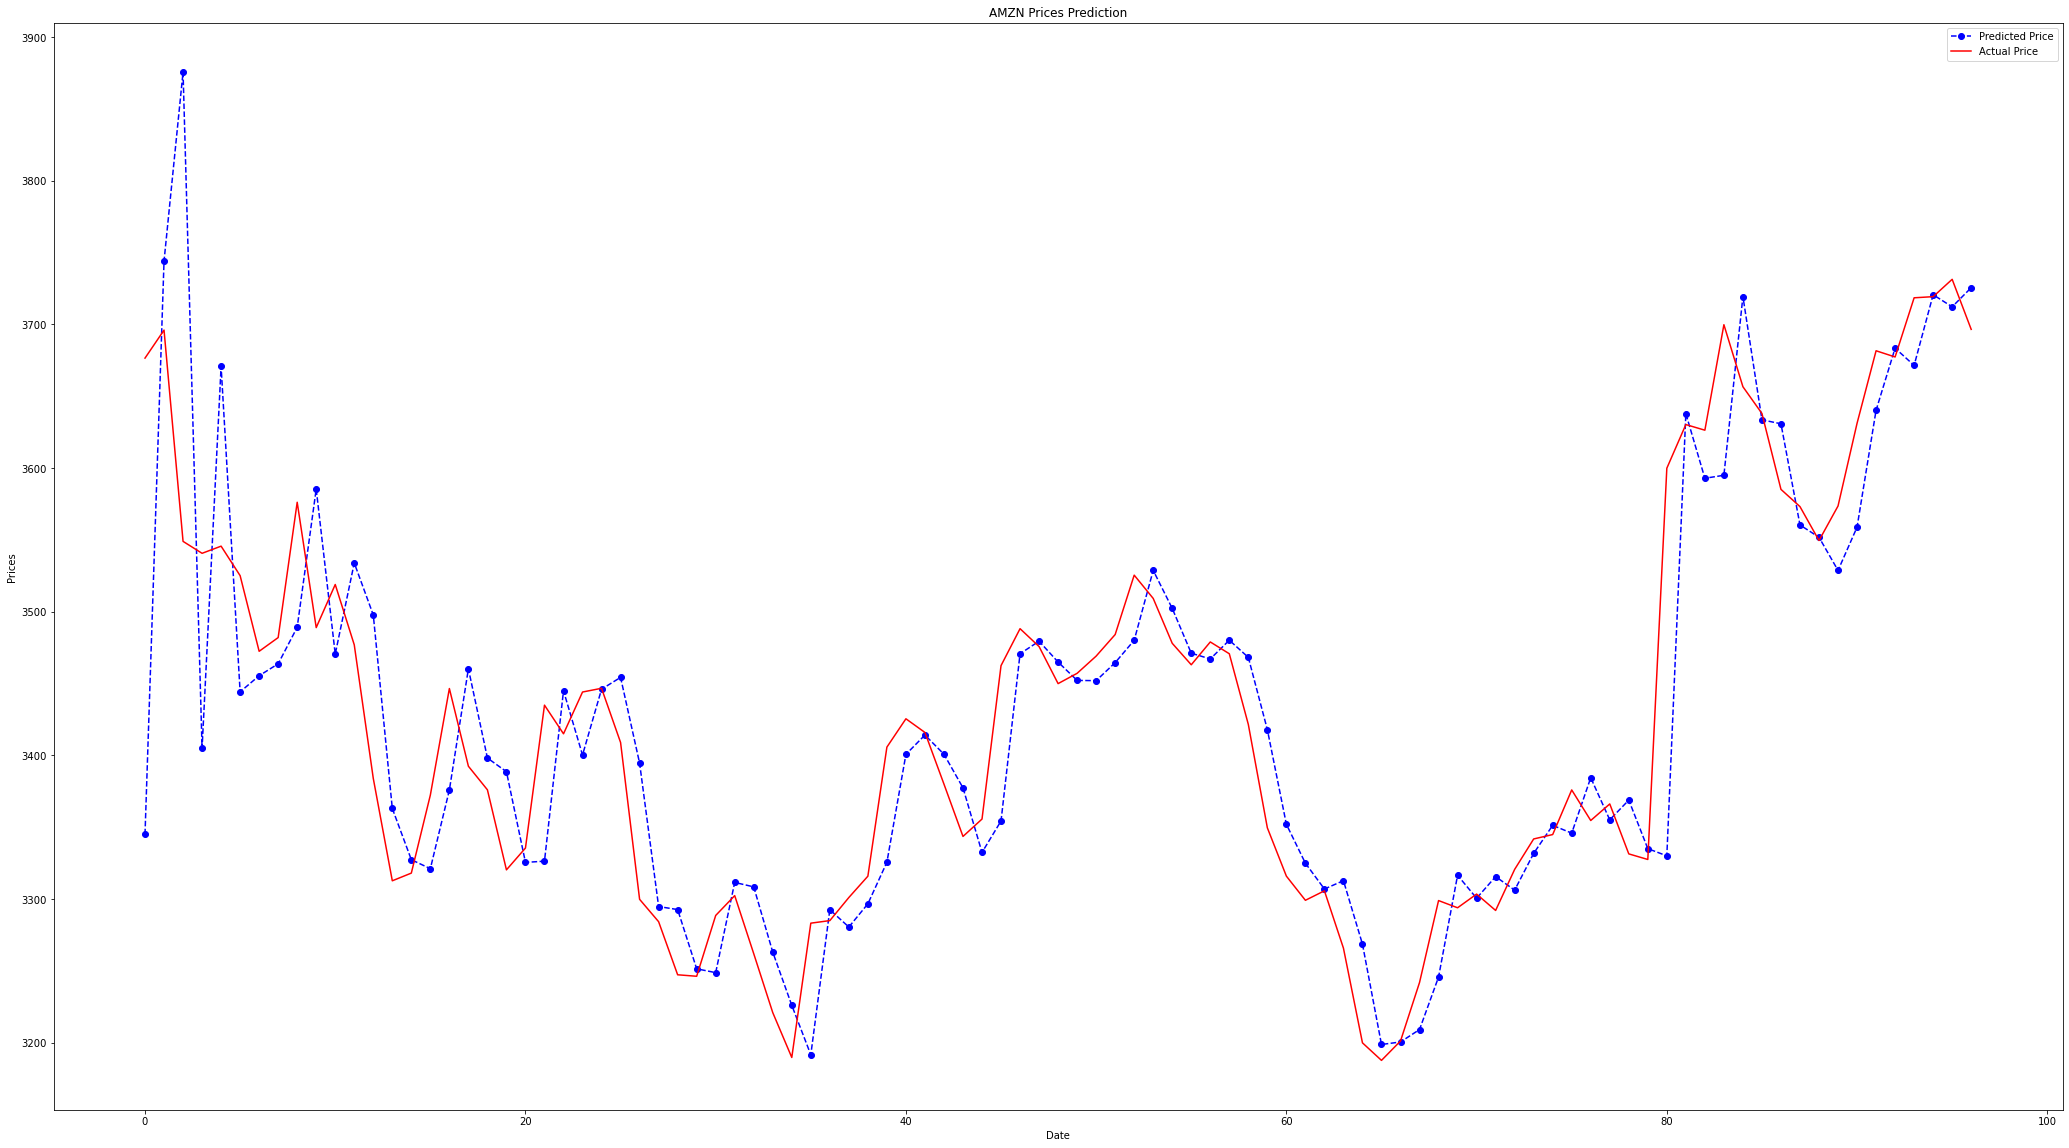

In [224]:
test_range = amzn_df[0:int(len(amzn_df)*.7)].index
plt.plot(test_range, model_predictions, color='blue', marker='o',
        linestyle ='dashed', label='Predicted Price')
plt.plot(test_range, test, color='red', label='Actual Price')
plt.title('AMZN Prices Prediction')
plt.xlabel('Date')
from pylab import rcParams
rcParams['figure.figsize'] = 36, 20
plt.ylabel('Prices')
plt.legend()
plt.show()

#### ARIMA has MAE of 45.5 for Amazon and took 14.6 seconds to run. There is not currently a method to predict tomorrow's close price with this model. I will now look at the daily model

In [331]:
xg_daily_df, xg_daily_model, prediction_daily_df, daily_mae = build_general_model_daily_prediction_df('AMZN')

In [293]:
fig = px.line(xg_daily_df, x='Date', y='value', color='data_category', markers=True,
              title = 'Daily Prediction For AMZN, Next Day Prediction: '+ \
              str(make_tomorrow_pred('AAPL', prediction_daily_df, xg_daily_model)) + '+/- '+str(daily_mae)
             )
fig.show()

#### Daily Stock model took 10.6 seconds and has an MAE of 73.4

In [332]:
xg_hourly_df, xg_hourly_model, prediction_hourly_df, hourly_mae = build_general_model_hourly_prediction_df('AMZN')

In [249]:
fig = px.line(xg_hourly_df, x='Time', y='value', color='data_category', markers=True,
              title = 'Hourly Prediction For AMZN, Next Hour Prediction: '+ \
              str(make_next_hour_pred('AMZN', prediction_hourly_df, xg_hourly_model)) + ' +/- '+str(hourly_mae)
             )
fig.show()

#### Hourly modeling takes 1/2 of a second with an MAE of 44.5

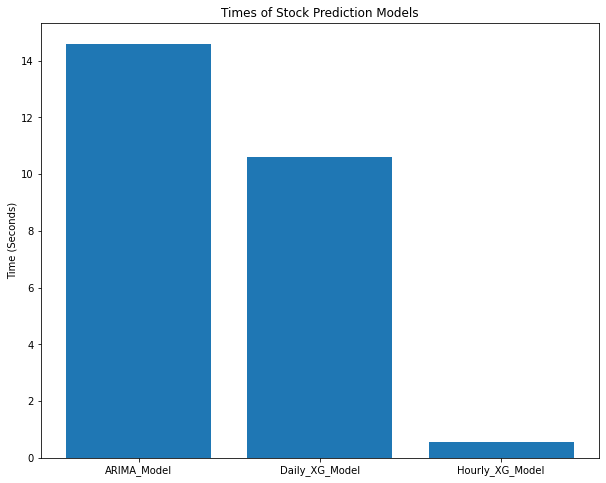

In [258]:

labels_time = ['ARIMA_Model', 'Daily_XG_Model', 'Hourly_XG_Model']
times = [14.6, 10.6, .573]



fig, ax = plt.subplots(figsize = (10,8))
ax.bar(x = labels_time, height = times )
ax.set_title('Times of Stock Prediction Models')
ax.set_ylabel('Time (Seconds)')
plt.show()

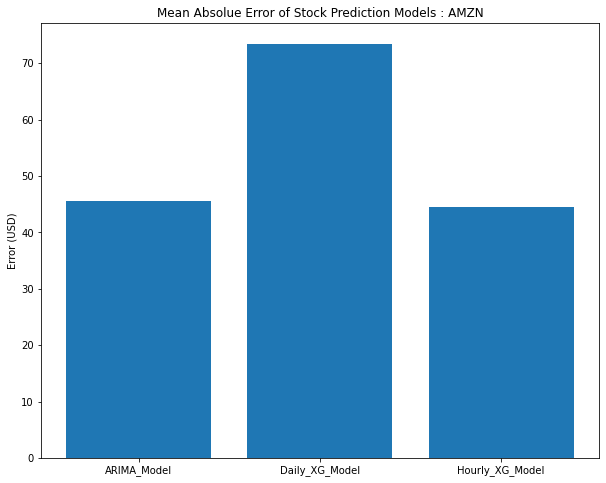

In [260]:
labels_mae = ['ARIMA_Model', 'Daily_XG_Model', 'Hourly_XG_Model']
times = [45.5, 73.45, 44.5]



fig, ax = plt.subplots(figsize = (10,8))
ax.bar(x = labels_time, height = times )
ax.set_title('Mean Absolue Error of Stock Prediction Models : AMZN')
ax.set_ylabel('Error (USD)')
plt.show()

## Adding news sentiment helps the xgboost model performance.

In [333]:
xg_daily_df, xg_daily_model, prediction_daily_df, daily_mae = build_general_model_daily_prediction_df('MSFT')

In [262]:
prediction_daily_df

,Close_1day,Close_2day,Close_3day,High_1day,High_2day,High_3day,Cot_1day,Cot_2day,Cot_3day,Vol_1day,Vol_2day,Vol_3day,value,Date,News_Sentiment_1day
0,341.270000,339.119995,339.510010,342.450000,342.190002,340.670013,0.00914,0.00053,0.01141,22464306.0,19053400.0,20886800.0,343.110000,2021-11-19,0.060375
1,339.119995,339.510010,336.070007,342.190002,340.670013,337.880005,0.00053,0.01141,-0.00436,19053400.0,20886800.0,16723000.0,341.270000,2021-11-18,0.035617
2,339.510010,336.070007,336.720001,340.670013,337.880005,337.230011,0.01141,-0.00436,0.00839,20886800.0,16723000.0,23822000.0,339.119995,2021-11-17,0.168657
3,336.070007,336.720001,332.429993,337.880005,337.230011,333.769989,-0.00436,0.00839,0.00356,16723000.0,23822000.0,16849800.0,339.510010,2021-11-16,0.203869
4,336.720001,332.429993,330.799988,337.230011,333.769989,334.630005,0.00839,0.00356,-0.01127,23822000.0,16849800.0,25500900.0,336.070007,2021-11-15,0.243125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,243.080002,245.179993,248.149994,246.410004,246.589996,249.179993,-0.01295,-0.00556,0.01046,20168000.0,24970200.0,23901100.0,243.119995,2021-05-19,0.231454
130,245.179993,248.149994,243.029999,246.589996,249.179993,245.600006,-0.00556,0.01046,0.00509,24970200.0,23901100.0,29624300.0,243.080002,2021-05-18,0.215670
131,248.149994,243.029999,239.000000,249.179993,245.600006,244.380005,0.01046,0.00509,-0.01309,23901100.0,29624300.0,36684400.0,245.179993,2021-05-17,0.155600
132,243.029999,239.000000,246.229996,245.600006,244.380005,246.600006,0.00509,-0.01309,0.00687,29624300.0,36684400.0,33641600.0,248.149994,2021-05-14,0.065010


In [264]:
import seaborn as sns

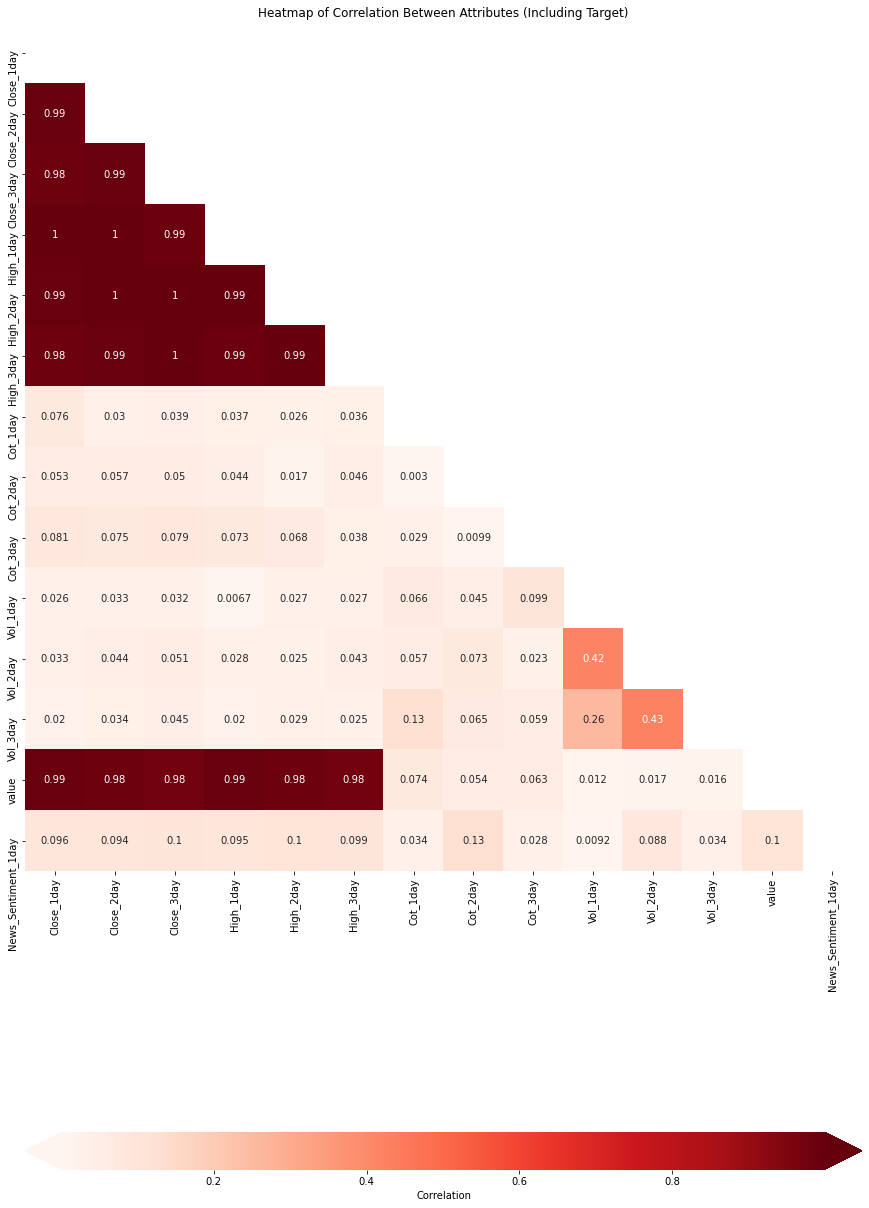

In [265]:

corr = prediction_daily_df.corr().abs()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(15, 24))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    cmap='Reds',
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

#### The news sentiment has a 10% Pearson correlation with the target close price.

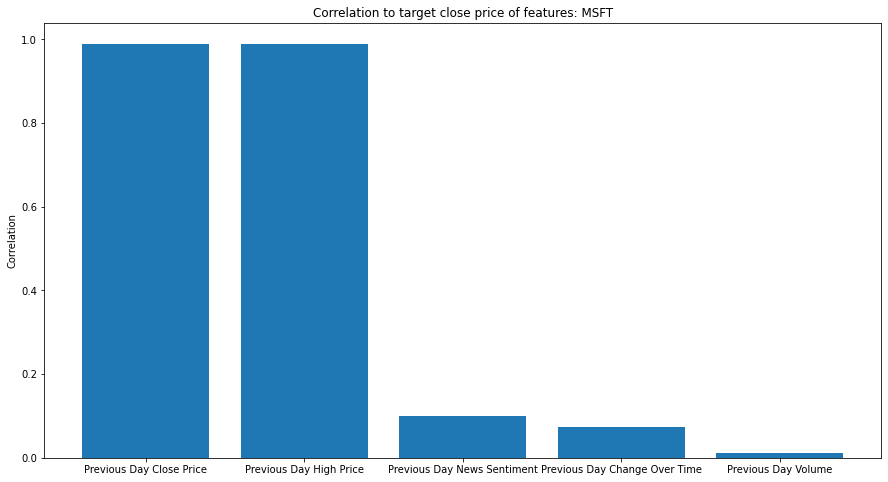

In [268]:
labels = ['Previous Day Close Price', 'Previous Day High Price', 'Previous Day News Sentiment',
         'Previous Day Change Over Time', 'Previous Day Volume']
corrs = [.99, .99 , .1, .074, .012]



fig, ax = plt.subplots(figsize = (15,8))
ax.bar(x = labels, height = corrs )
ax.set_title('Correlation to target close price of features: MSFT')
ax.set_ylabel('Correlation')
plt.show()

## When predicting stocks there is lots of noise introduced. 

#### To show this, I will show model performance of the hourly model with different intervals of test and train data.

In [279]:
def build_general_model_hourly_prediction_df(stock):
    prediction_df = build_xgboost_hourly_df(stock)

    test_data, train_data = prediction_df[0:int(len(prediction_df)*.05)], \
                            prediction_df[int(len(prediction_df)*.05):]
    
    X_test = test_data.drop(columns = ['Time', 'value'])

    y_train = train_data.value
    X_train = train_data.drop(columns = ['Time', 'value'])
    y_test = test_data.value

    xg = GradientBoostingRegressor()
    xg.fit(X_train, y_train)
    y_pred = pd.Series(xg.predict(X_test))
    mae = np.sqrt(mean_squared_error(y_test, y_pred))
    
    xgboost_prediction_df = pd.DataFrame(columns = ['value', 'data_category', 'Time'])
    combined_list = pd.concat([y_test, y_train, y_pred])
    combined_list.reset_index(drop = True, inplace = True)

    xgboost_prediction_df.value = combined_list
    xgboost_prediction_df.Time = prediction_df.Time



    test_cutoff = len(y_test)
    pred_cutoff = len(y_test) + len(y_train)
    counter = 0
    for i in range(len(combined_list)):
        if (counter > test_cutoff)&(counter < pred_cutoff):
            xgboost_prediction_df.data_category[i] = 'train'
        elif (counter <= test_cutoff):
            xgboost_prediction_df.data_category[i] = 'test'
        elif (counter >= pred_cutoff):
            xgboost_prediction_df.data_category[i] = 'pred'
        counter += 1
            
    pred_dates = list(xgboost_prediction_df.iloc[:len(y_test)].Time)
    count = 0
    i = 0
    for date in xgboost_prediction_df.Time:
        if date is np.nan:
            xgboost_prediction_df.Time[count] = pred_dates[i]
            i += 1
        count += 1
        
    #return pred_dates, xgboost_prediction_df
    return xgboost_prediction_df, xg, prediction_df, mae

#### 90/10 Split

In [334]:
xg_hourly_df, xg_hourly_model, prediction_hourly_df, hourly_mae = build_general_model_hourly_prediction_df('TSLA')

In [272]:
fig = px.line(xg_hourly_df, x='Time', y='value', color='data_category', markers=True,
              title = '90/10 SPLIT, Hourly Prediction For TSLA, Next Hour Prediction: '+ \
              str(make_next_hour_pred('TSLA', prediction_hourly_df, xg_hourly_model)) + ' +/- '+str(hourly_mae)
             )
fig.show()

#### 75/25 split

In [335]:
xg_hourly_df, xg_hourly_model, prediction_hourly_df, hourly_mae = build_general_model_hourly_prediction_df('TSLA')

In [275]:
fig = px.line(xg_hourly_df, x='Time', y='value', color='data_category', markers=True,
              title = '75/25 SPLIT, Hourly Prediction For TSLA, Next Hour Prediction: '+ \
              str(make_next_hour_pred('TSLA', prediction_hourly_df, xg_hourly_model)) + ' +/- '+str(hourly_mae)
             )
fig.show()

#### 60/40 Split

In [336]:
xg_hourly_df, xg_hourly_model, prediction_hourly_df, hourly_mae = build_general_model_hourly_prediction_df('TSLA')

In [278]:
fig = px.line(xg_hourly_df, x='Time', y='value', color='data_category', markers=True,
              title = '60/40 SPLIT, Hourly Prediction For TSLA, Next Hour Prediction: '+ \
              str(make_next_hour_pred('TSLA', prediction_hourly_df, xg_hourly_model)) + ' +/- '+str(hourly_mae)
             )
fig.show()

#### 95/5 Split

In [337]:
xg_hourly_df, xg_hourly_model, prediction_hourly_df, hourly_mae = build_general_model_hourly_prediction_df('TSLA')

In [281]:
fig = px.line(xg_hourly_df, x='Time', y='value', color='data_category', markers=True,
              title = '95/5 SPLIT, Hourly Prediction For TSLA, Next Hour Prediction: '+ \
              str(make_next_hour_pred('TSLA', prediction_hourly_df, xg_hourly_model)) + ' +/- '+str(hourly_mae)
             )
fig.show()

# Conclusions

- News sentiment provides valuable information to models.
- Arima models are too slow and ineffective for live dashboard predictions
- Stock market prediction models are very prone to overfitting. Test data must be very close to training data.

# Further Work

- Provide with more time, I would :
 - Investigate if/how insider training affects model performance
 - Implement analyst ratings to the prediction model
 - Investigate actively raising stocks to determine causers of such movement